# AutoML with TPOT using Adversary Emulation (C2) as datagen - Supervised and Deep Learning with Genetic Programming

# Installations

The installation is mostly automated.

A file in the same directory named "thesis_ro" will be required, which should contain your GitHub read-only token.

The file has one line:


`echo "GITHUB_PERSONAL_ACCESS_TOKEN="ghp_..." > thesis_ro`

In [8]:
import sys
import os
import subprocess

IN_COLAB = 'google.colab' in sys.modules

if not IN_COLAB:
  pass

else:
  subprocess.run('''
    source <(curl -s https://raw.githubusercontent.com/norandom/log2ml/main/dependencies/install.sh)
    ''',
    shell=True, check=True, executable='/bin/bash')



In [9]:
from dotenv import load_dotenv
import os

load_dotenv("thesis_ro", verbose=True)  # take environment variables from the file
token = os.getenv('GITHUB_PERSONAL_ACCESS_TOKEN')
if len(token) > 0:
  print("ok")
else:
  print("no token")

ok


# Data download: captured Sysmon logs from the AE lab

These samples contain Sysmon log activity of Dropper Malware (C2 Dropper, MS Excel VBA, Covenant).

No AE campaigns, just the Dropper itself.

We are looking at 1000 documents, some malicious and some not. Which ones are malicious? How does the VBA Excel malware behave? How not? Can ML help to find out?

In [10]:
from github import Github
import requests
from tqdm.notebook import tqdm


def get_specific_file_from_tagged_release(token, repo_name, tag_name, filename):
    g = Github(token)
    repo = g.get_repo(repo_name)
    releases = repo.get_releases()

    for release in releases:
        if release.tag_name == tag_name:
            for asset in release.get_assets():
                if asset.name == filename:
                    return asset.url
    print("File not found. Try get_specific_file_from_latest_release() instead.")
    return None

def get_specific_file_from_latest_release(token, repo_name, filename):
    g = Github(token)
    repo = g.get_repo(repo_name)
    release = repo.get_latest_release()

    for asset in release.get_assets():
        if asset.name == filename:
            return asset.url  # Use asset.url which points to API URL needing headers

def download_file(url, token, save_path):
    headers = {'Authorization': f'token {token}', 'Accept': 'application/octet-stream'}
    # First request to handle GitHub's redirection and authentication properly
    with requests.get(url, headers=headers, stream=True) as initial_response:
        initial_response.raise_for_status()  # Ensure the initial request is successful
        # Follow redirection if necessary, maintaining headers
        if initial_response.history:
            url = initial_response.url  # Updated URL after redirection

        # Now, proceed with downloading the file
        with requests.get(url, headers=headers, stream=True) as response:
            response.raise_for_status()
            total_size_in_bytes = int(response.headers.get('content-length', 0))
            block_size = 1024

            progress_bar = tqdm(total=total_size_in_bytes, unit='iB', unit_scale=True)
            with open(save_path, 'wb') as file:
                for data in response.iter_content(block_size):
                    progress_bar.update(len(data))
                    file.write(data)
            progress_bar.close()

            if total_size_in_bytes != 0 and progress_bar.n != total_size_in_bytes:
                print("ERROR, something went wrong")
            else:
                print(f"File downloaded successfully and saved as {save_path}")

# Your GitHub token
github_token = token

# Repository name
repository_name = "norandom/log2ml"

# File name to search for
file_name = "lab_logs_blindtest_activity_sysmon_1000samples_july_28_2024.csv"

# Get the download URL of the specific file
# download_url = get_specific_file_from_latest_release(github_token, repository_name, file_name)
download_url = get_specific_file_from_tagged_release(github_token, repository_name, "lab", file_name)
print(download_url)

if download_url:
    local_file_path = file_name
    download_file(download_url, github_token, local_file_path)
else:
    print("File not found.")

https://api.github.com/repos/norandom/log2ml/releases/assets/182477524


  0%|          | 0.00/8.04M [00:00<?, ?iB/s]

File downloaded successfully and saved as lab_logs_blindtest_activity_sysmon_1000samples_july_28_2024.csv


# Download pre-trained BPE Tokenizer from the project

In [75]:
# File name to search for
file_name = "log_tokenizer.json"

# Get the download URL of the specific file
# download_url = get_specific_file_from_latest_release(github_token, repository_name, file_name)
download_url = get_specific_file_from_tagged_release(github_token, repository_name, "lab", file_name)
print(download_url)

if download_url:
    local_file_path = file_name
    download_file(download_url, github_token, local_file_path)
else:
    print("File not found.")

https://api.github.com/repos/norandom/log2ml/releases/assets/182534935


  0%|          | 0.00/1.72M [00:00<?, ?iB/s]

File downloaded successfully and saved as log_tokenizer.json


# Download pre-vecorized data from the project

In [11]:
# File name to search for
file_name = "lab_logs_blindtest_activity_sysmon_1000samples_july_28_2024_filtered_vectors.parquet"

# Get the download URL of the specific file
# download_url = get_specific_file_from_latest_release(github_token, repository_name, file_name)
download_url = get_specific_file_from_tagged_release(github_token, repository_name, "lab", file_name)
print(download_url)

if download_url:
    local_file_path = file_name
    download_file(download_url, github_token, local_file_path)
else:
    print("File not found.")

https://api.github.com/repos/norandom/log2ml/releases/assets/182698628


  0%|          | 0.00/3.29M [00:00<?, ?iB/s]

File downloaded successfully and saved as lab_logs_blindtest_activity_sysmon_1000samples_july_28_2024_filtered_vectors.parquet


# ETL and labeling

In [1]:
import polars as pl

csv_file_path = 'lab_logs_blindtest_activity_sysmon_1000samples_july_28_2024.csv'

# Load the CSV file into a DataFrame
df = pl.read_csv(csv_file_path)

# Show the DataFrame to confirm it's loaded correctly
print(df)

shape: (13_455, 7)
┌──────────────┬─────────────┬─────────────┬─────────────┬─────────────┬─────────────┬─────────────┐
│ @timestamp   ┆ host.hostna ┆ host.ip     ┆ log.level   ┆ winlog.even ┆ winlog.task ┆ message     │
│ ---          ┆ me          ┆ ---         ┆ ---         ┆ t_id        ┆ ---         ┆ ---         │
│ str          ┆ ---         ┆ str         ┆ str         ┆ ---         ┆ str         ┆ str         │
│              ┆ str         ┆             ┆             ┆ i64         ┆             ┆             │
╞══════════════╪═════════════╪═════════════╪═════════════╪═════════════╪═════════════╪═════════════╡
│ 2024-07-28T1 ┆ win10       ┆ fe80::c1af: ┆ information ┆ 13          ┆ Registry    ┆ Registry    │
│ 5:09:33.716Z ┆             ┆ 35de:6006:d ┆             ┆             ┆ value set   ┆ value set:  │
│              ┆             ┆ 4cf         ┆             ┆             ┆ (rule:      ┆ RuleName:   │
│              ┆             ┆             ┆             ┆             ┆

## Sorting the data

By defeault Elasticsearch sorts the data based on when it was received. Not based on the log timestamp.

In [2]:
# sort data

# Convert @timestamp to timestamp type
df = df.with_columns(
    pl.col("@timestamp").str.to_datetime()
)


df = df.sort("@timestamp")

## Denoised vector generation

Here system specific strings get removed. This improves the transferability.

In [3]:
def remove_keyword_lines(batch, keywords):
    def modify_message(message):
        lines = message.split('\n')
        processed_lines = []
        processed_keywords = set()

        for line in lines:
            processed = False
            for keyword in keywords:
                if line.startswith(f"{keyword}:") and keyword not in processed_keywords:
                    processed_keywords.add(keyword)
                    if keyword == 'User':
                        parts = line.split('\\')
                        if len(parts) > 1:
                            processed_lines.append(f"User: {parts[1]}")
                    elif keyword in ['SourceHostname', 'DestinationHostname']:
                        parts = line.split(':', 1)
                        if len(parts) > 1:
                            hostname = parts[1].strip().split('.')[0]
                            processed_lines.append(f"{keyword}: {hostname}")
                    elif keyword == 'QueryName':
                        parts = line.split(':', 1)
                        if len(parts) > 1:
                            domain = parts[1].strip().split('.')
                            if len(domain) > 0:
                                processed_lines.append(f"QueryName: {domain[0]}")
                    else:
                        processed_lines.append(line)
                    processed = True
                    break
            if not processed:
                processed_lines.append(line)

        return '\n'.join(processed_lines)

    return batch.map_elements(modify_message, return_dtype=pl.Utf8)

# Keywords to filter or process
keywords_to_filter = ["UtcTime", "SourceProcessGUID", "ProcessGuid", "TargetProcessGUID", "TargetObject", "FileVersion", "Hashes", "LogonGuid", "LogonId", "CreationUtcTime", "User", "ParentProcessGuid", "SourceHostname", "DestinationHostname", "QueryName"]

# Apply the transformation to the 'message' column using map_batches
df_f = df.with_columns(
    pl.col("message").map_batches(lambda batch: remove_keyword_lines(batch, keywords_to_filter), return_dtype=pl.Utf8).alias("filtered_message")
)

# Show the DataFrame to confirm it's loaded correctly
print(df_f)

shape: (13_455, 8)
┌────────────┬────────────┬────────────┬───────────┬───────────┬───────────┬───────────┬───────────┐
│ @timestamp ┆ host.hostn ┆ host.ip    ┆ log.level ┆ winlog.ev ┆ winlog.ta ┆ message   ┆ filtered_ │
│ ---        ┆ ame        ┆ ---        ┆ ---       ┆ ent_id    ┆ sk        ┆ ---       ┆ message   │
│ datetime[μ ┆ ---        ┆ str        ┆ str       ┆ ---       ┆ ---       ┆ str       ┆ ---       │
│ s, UTC]    ┆ str        ┆            ┆           ┆ i64       ┆ str       ┆           ┆ str       │
╞════════════╪════════════╪════════════╪═══════════╪═══════════╪═══════════╪═══════════╪═══════════╡
│ 2024-07-28 ┆ win10      ┆ fe80::c1af ┆ informati ┆ 3         ┆ Network   ┆ Network   ┆ Network   │
│ 15:08:24.2 ┆            ┆ :35de:6006 ┆ on        ┆           ┆ connectio ┆ connectio ┆ connectio │
│ 77 UTC     ┆            ┆ :d4cf      ┆           ┆           ┆ n         ┆ n         ┆ n         │
│            ┆            ┆            ┆           ┆           ┆ detecte

In [4]:
import re

# Extract relevant information using regular expressions
def extract_info(text):
    image = re.search(r"Image: (.*?\.exe)", text, re.IGNORECASE)
    target_filename = re.search(r"TargetFilename: (.*?\.exe)", text, re.IGNORECASE)
    parent_image = re.search(r"ParentImage: (.*?\.exe)", text, re.IGNORECASE)

    return {
        "image": image.group(1) if image else "",
        "target_filename": target_filename.group(1) if target_filename else "",
        "parent_image": parent_image.group(1).split("\\")[-1] if parent_image else "",
        "text": text
    }

# Apply extraction to the Polars DataFrame using map_elements
df_f = df_f.with_columns(
    pl.col("filtered_message").map_elements(lambda x: extract_info(x), return_dtype=pl.Object).alias("extracted_info")
)

# Extract fields from the extracted_info column using map_elements with return_dtype
df_f = df_f.with_columns(
    pl.col("extracted_info").map_elements(lambda x: x['image'], return_dtype=pl.Utf8).alias("image"),
    pl.col("extracted_info").map_elements(lambda x: x['target_filename'], return_dtype=pl.Utf8).alias("target_filename"),
    pl.col("extracted_info").map_elements(lambda x: x['parent_image'], return_dtype=pl.Utf8).alias("parent_image"),
    pl.col("extracted_info").map_elements(lambda x: x['text'], return_dtype=pl.Utf8).alias("text")
).drop("extracted_info")

print(df_f.head())

# Print the unique values in the parent_image column
print(df_f["parent_image"].value_counts())
print(df_f["target_filename"].value_counts())

shape: (5, 12)
┌───────────┬───────────┬───────────┬───────────┬───┬───────────┬───────────┬───────────┬──────────┐
│ @timestam ┆ host.host ┆ host.ip   ┆ log.level ┆ … ┆ image     ┆ target_fi ┆ parent_im ┆ text     │
│ p         ┆ name      ┆ ---       ┆ ---       ┆   ┆ ---       ┆ lename    ┆ age       ┆ ---      │
│ ---       ┆ ---       ┆ str       ┆ str       ┆   ┆ str       ┆ ---       ┆ ---       ┆ str      │
│ datetime[ ┆ str       ┆           ┆           ┆   ┆           ┆ str       ┆ str       ┆          │
│ μs, UTC]  ┆           ┆           ┆           ┆   ┆           ┆           ┆           ┆          │
╞═══════════╪═══════════╪═══════════╪═══════════╪═══╪═══════════╪═══════════╪═══════════╪══════════╡
│ 2024-07-2 ┆ win10     ┆ fe80::c1a ┆ informati ┆ … ┆ C:\Window ┆           ┆           ┆ Network  │
│ 8 15:08:2 ┆           ┆ f:35de:60 ┆ on        ┆   ┆ s\System3 ┆           ┆           ┆ connecti │
│ 4.277 UTC ┆           ┆ 06:d4cf   ┆           ┆   ┆ 2\svchost ┆           

In [5]:
def is_temp_folder(path):
    if not path:
        return False

    # Convert path to lowercase for case-insensitive comparison
    lower_path = path.lower()

    # Check if the path contains "\temp\" or ends with "\temp"
    if "\temp\\" in lower_path or lower_path.endswith("\\temp"):
        return True

    # Check for specific temp folder patterns
    temp_patterns = [
        r"c:\windows\temp",
        r"c:\users\*\appdata\local\temp",
        r"c:\users\*\appdata\locallow\temp",
        r"c:\users\*\appdata\roaming\temp",
        r"c:\temp",
        r"c:\windows\softwaredistriβution\download",
    ]

    for pattern in temp_patterns:
        if pattern.startswith(r"c:\users\*"):
            # Replace the wildcard with the actual username
            user_pattern = pattern.replace("*", path.split("\\")[2])
            if lower_path.startswith(user_pattern):
                return True
        elif lower_path.startswith(pattern):
            return True

    return False

def get_filename(path):
    return path.split("\\")[-1] if path else ""

# Add new columns to the DataFrame in a single operation
df_f = df_f.with_columns([
    pl.col("target_filename").map_elements(lambda x: "Yes" if is_temp_folder(x) else "No").alias("temp_folder"),
    pl.col("target_filename").map_elements(get_filename).alias("filename")
])

# Print the first few rows where temp_folder is "Yes"
print(df_f.filter(pl.col("temp_folder") == "Yes").select(["target_filename", "temp_folder", "filename"]).head(10))

# Print value counts for temp_folder column
print(df_f["temp_folder"].value_counts())

shape: (10, 3)
┌───────────────────────────────────┬─────────────┬────────────────────────┐
│ target_filename                   ┆ temp_folder ┆ filename               │
│ ---                               ┆ ---         ┆ ---                    │
│ str                               ┆ str         ┆ str                    │
╞═══════════════════════════════════╪═════════════╪════════════════════════╡
│ C:\Users\student\AppData\Local\T… ┆ Yes         ┆ file.exe               │
│ C:\Users\student\AppData\Local\T… ┆ Yes         ┆ cli-32.exe             │
│ C:\Users\student\AppData\Local\T… ┆ Yes         ┆ cli-64.exe             │
│ C:\Users\student\AppData\Local\T… ┆ Yes         ┆ cli-arm64.exe          │
│ …                                 ┆ …           ┆ …                      │
│ C:\Users\student\AppData\Local\T… ┆ Yes         ┆ gui-64.exe             │
│ C:\Users\student\AppData\Local\T… ┆ Yes         ┆ gui-arm64.exe          │
│ C:\Users\student\AppData\Local\T… ┆ Yes         ┆ gui.exe  

In [6]:
count = df_f.filter((pl.col("temp_folder") == "Yes") & pl.col("filename").str.contains("file.exe")).height
print(count)

114


## Store the data as CSV and JSON

In [7]:
df_f.write_csv("lab_logs_blindtest_activity_sysmon_1000samples_july_28_2024_filtered.csv", include_header=True)

In [8]:
df_f.write_json("lab_logs_blindtest_activity_sysmon_1000samples_july_28_2024_filtered.json")

# Labeling based on Python

In [9]:
def define_label(row):
    conditions = {
        ("EXCEL.EXE" in row['image'] and ".exe" in row['target_filename'] and row['temp_folder'] == "Yes"): "bad",
        (row['parent_image'] == "EXCEL.EXE" and row['temp_folder'] == "Yes" and row['image'].lower().endswith('.exe')): "bad",
        # Add more conditions here if needed
    }
    return conditions.get(True, "good")

# Apply the label to the DataFrame
df_f = df_f.with_columns(pl.struct(df_f.columns).map_elements(define_label).alias("label"))

# Print the first few rows where the label is "bad"
print(df_f.filter(pl.col("label") == "bad").select(["image", "parent_image", "target_filename", "temp_folder", "label"]).head(10))

# Print value counts for the label column
print(df_f["label"].value_counts())

shape: (10, 5)
┌──────────────────────────────┬──────────────┬──────────────────────────────┬─────────────┬───────┐
│ image                        ┆ parent_image ┆ target_filename              ┆ temp_folder ┆ label │
│ ---                          ┆ ---          ┆ ---                          ┆ ---         ┆ ---   │
│ str                          ┆ str          ┆ str                          ┆ str         ┆ str   │
╞══════════════════════════════╪══════════════╪══════════════════════════════╪═════════════╪═══════╡
│ C:\Program Files\Microsoft   ┆              ┆ C:\Users\student\AppData\Loc ┆ Yes         ┆ bad   │
│ Offic…                       ┆              ┆ al\T…                        ┆             ┆       │
│ C:\Program Files\Microsoft   ┆              ┆ C:\Users\student\AppData\Loc ┆ Yes         ┆ bad   │
│ Offic…                       ┆              ┆ al\T…                        ┆             ┆       │
│ C:\Program Files\Microsoft   ┆              ┆ C:\Users\student\AppData\Loc

In [10]:
# Filter the DataFrame for rows where label is "bad" and select specified columns
bad_df = df_f.filter(pl.col("label") == "bad").select([
    "image", "parent_image", "filename", "temp_folder", "label"
])

# Write the filtered DataFrame to a CSV file
bad_df.write_csv("bad.csv")

# Print the first 10 rows of the bad DataFrame
print(bad_df.head(10))

# Print the total count of "bad" rows
total_bad_count = bad_df.shape[0]
print(f"\nTotal number of 'bad' rows: {total_bad_count}")

shape: (10, 5)
┌───────────────────────────────────┬──────────────┬──────────┬─────────────┬───────┐
│ image                             ┆ parent_image ┆ filename ┆ temp_folder ┆ label │
│ ---                               ┆ ---          ┆ ---      ┆ ---         ┆ ---   │
│ str                               ┆ str          ┆ str      ┆ str         ┆ str   │
╞═══════════════════════════════════╪══════════════╪══════════╪═════════════╪═══════╡
│ C:\Program Files\Microsoft Offic… ┆              ┆ file.exe ┆ Yes         ┆ bad   │
│ C:\Program Files\Microsoft Offic… ┆              ┆ file.exe ┆ Yes         ┆ bad   │
│ C:\Program Files\Microsoft Offic… ┆              ┆ file.exe ┆ Yes         ┆ bad   │
│ C:\Program Files\Microsoft Offic… ┆              ┆ file.exe ┆ Yes         ┆ bad   │
│ …                                 ┆ …            ┆ …        ┆ …           ┆ …     │
│ C:\Program Files\Microsoft Offic… ┆              ┆ file.exe ┆ Yes         ┆ bad   │
│ C:\Program Files\Microsoft Offic… ┆  

# Vectorization with Linformer

In [11]:
import torch
torch.cuda.empty_cache()

In [12]:
# Linformer parameter 1:1 from the researchers
# then the input_size is determined based on the max no. of tokens
# the positional embedding flag is on by default

from linformer_pytorch import LinformerLM
import torch

linformer_model = LinformerLM(
        num_tokens=30000, # Number of tokens in the LM
        input_size=700, # Dimension 1 of the input
        channels=64, # Dimension 2 of the input
        dim_d=None, # Overwrites the inner dim of the attention heads. If None, sticks with the recommended channels // nhead, as in the "Attention is all you need" paper
        dim_k=128, # The second dimension of the P_bar matrix from the paper
        dim_ff=128, # Dimension in the feed forward network
        dropout_ff=0.15, # Dropout for feed forward network
        nhead=4, # Number of attention heads
        depth=2, # How many times to run the model
        dropout=0.1, # How much dropout to apply to P_bar after softmax
        activation="gelu", # What activation to use. Currently, only gelu and relu supported, and only on ff network.
        checkpoint_level="C0", # What checkpoint level to use. For more information, see below.
        parameter_sharing="layerwise", # What level of parameter sharing to use. For more information, see below.
        k_reduce_by_layer=0, # Going down `depth`, how much to reduce `dim_k` by, for the `E` and `F` matrices. Will have a minimum value of 1.
        full_attention=False, # Use full attention instead, for O(n^2) time and space complexity. Included here just for comparison
        include_ff=True, # Whether or not to include the Feed Forward layer
        w_o_intermediate_dim=None, # If not None, have 2 w_o matrices, such that instead of `dim*nead,channels`, you have `dim*nhead,w_o_int`, and `w_o_int,channels`
        emb_dim=128, # If you want the embedding dimension to be different than the channels for the Linformer
        causal=False, # If you want this to be a causal Linformer, where the upper right of the P_bar matrix is masked out.
        method="learnable", # The method of how to perform the projection. Supported methods are 'convolution', 'learnable', and 'no_params'
        ff_intermediate=None, # See the section below for more information
        ).cuda()

## Vectorize text column in the DataFrame

In [123]:
print(df_f.columns)
print(df_f[["label", "filtered_message"]])

import polars as pl
import random

bad_messages = df_f.filter(pl.col('label') == 'bad').select('filtered_message')
good_messages = df_f.filter(pl.col('label') == 'good').select('filtered_message')

random_bad_message = ""
random_good_message = ""

if bad_messages.height > 0:
    # Get a random index
    random_index = random.randint(0, bad_messages.height - 1)

    # Select the message at that random index
    random_bad_message = bad_messages.row(random_index)[0]
    print(random_bad_message)
else:
    print("No bad messages labeled found.")

print("\n\n")

if good_messages.height > 0:
    # Get a random index
    random_index = random.randint(0, good_messages.height - 1)

    # Select the message at that random index
    random_good_message = good_messages.row(random_index)[0]
    print(random_good_message)
else:
    print("No good messages labeled found.")

['@timestamp', 'host.hostname', 'host.ip', 'log.level', 'winlog.event_id', 'winlog.task', 'message', 'filtered_message', 'image', 'target_filename', 'parent_image', 'text', 'temp_folder', 'filename', 'label', 'message_vector']
shape: (13_455, 2)
┌───────┬──────────────────────────────┐
│ label ┆ filtered_message             │
│ ---   ┆ ---                          │
│ str   ┆ str                          │
╞═══════╪══════════════════════════════╡
│ good  ┆ Network connection detected: │
│       ┆ Rul…                         │
│ good  ┆ Network connection detected: │
│       ┆ Rul…                         │
│ good  ┆ Process accessed:            │
│       ┆ RuleName: -                  │
│       ┆ Ut…                          │
│ good  ┆ Process accessed:            │
│       ┆ RuleName: -                  │
│       ┆ Ut…                          │
│ …     ┆ …                            │
│ good  ┆ Process accessed:            │
│       ┆ RuleName: -                  │
│       ┆ Ut…   

In [127]:
from tokenizers import Tokenizer
import torch
import numpy as np
import polars as pl

# Load the custom tokenizer
tokenizer = Tokenizer.from_file("log_tokenizer.json")

# Define the device (assuming you're using PyTorch and want to specify CPU or GPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def vectorize_text(text):
    MAX_LENGTH = 700  # Define the maximum length of tokens for the model

    # Tokenize using the custom tokenizer
    encoded = tokenizer.encode(text)

    # Get token IDs
    input_ids = encoded.ids

    # Ensure the input_ids length is exactly MAX_LENGTH
    input_ids = input_ids[:MAX_LENGTH] if len(input_ids) > MAX_LENGTH else input_ids + [0] * (MAX_LENGTH - len(input_ids))

    # Convert to PyTorch tensor and move to the appropriate device
    input_ids = torch.tensor([input_ids], dtype=torch.long).to(device)

    # Get the model outputs, ensuring the input tensor is the correct size
    outputs = linformer_model(input_ids)  # Now passing the tensor directly

    # Assuming outputs is the tensor of interest
    vector = outputs.mean(dim=1).detach()  # Detach the tensor from the GPU
    return vector.cpu().numpy()  # Move tensor back to CPU and convert to numpy



In [15]:
# Assuming df_f is a Polars DataFrame with a column "filtered_message"
df_f = df_f.with_columns(
    pl.col("filtered_message").map_elements(lambda x: vectorize_text(x).flatten(), return_dtype=pl.Object).alias("message_vector")
)

In [39]:
# broken


import polars as pl
import numpy as np
import json

# Function to convert vector to string
def vector_to_string(vec):
    return json.dumps(vec.tolist())

# Function to convert string back to vector
def string_to_vector(s):
    return np.array(json.loads(s))

# Convert vector column to string representation
df_f = df_f.with_columns(
    pl.col("message_vector").map_elements(vector_to_string).alias("message_vector_str")
)

# Drop the original vector column
df_f = df_f.drop("message_vector")

# Write to Parquet
df_f.write_parquet("lab_logs_blindtest_activity_sysmon_1000samples_july_28_2024_filtered_with_vectors.parquet")

shape: (5, 1)
┌────────────────┐
│ message_vector │
│ ---            │
│ u32            │
╞════════════════╡
│ 30000          │
│ 30000          │
│ 30000          │
│ 30000          │
│ 30000          │
└────────────────┘
Sample vector length: 30000
Numpy vector shape: (30000,)


In [4]:
# broken

import pandas as pd
import numpy as np

# Read from Parquet using pandas
pdf_read = pd.read_parquet("lab_logs_blindtest_activity_sysmon_1000samples_july_28_2024_filtered_with_vectors.parquet")

# Convert lists back to numpy arrays if needed
pdf_read['message_vector'] = pdf_read['message_vector_str'].apply(np.array)

# Verify the shape of the vector
print(pdf_read['message_vector'].str.len().head())

# Check a sample vector to ensure dimensionality is preserved
sample_vector = pdf_read['message_vector'].iloc[0]
print(f"Sample vector shape: {sample_vector.shape}")

# If you need to convert back to Polars
df_read = pl.from_pandas(pdf_read)

# Verify in Polars
print(df_read.select(pl.col("message_vector").list.len()).head())

0    636264
1    636780
2    640357
3    640529
4    640428
Name: message_vector, dtype: int64


AttributeError: 'str' object has no attribute 'shape'

In [19]:
import polars as pl
import numpy as np

print(df_f)

print()
# Convert the 'message_vector' column to a NumPy array
X = np.array(df_f['message_vector'].to_list())
print("Original data shape:", X.shape)


shape: (13_455, 16)
┌────────────┬────────────┬────────────┬────────────┬───┬───────────┬──────────┬───────┬───────────┐
│ @timestamp ┆ host.hostn ┆ host.ip    ┆ log.level  ┆ … ┆ temp_fold ┆ filename ┆ label ┆ message_v │
│ ---        ┆ ame        ┆ ---        ┆ ---        ┆   ┆ er        ┆ ---      ┆ ---   ┆ ector     │
│ datetime[μ ┆ ---        ┆ str        ┆ str        ┆   ┆ ---       ┆ str      ┆ str   ┆ ---       │
│ s, UTC]    ┆ str        ┆            ┆            ┆   ┆ str       ┆          ┆       ┆ object    │
╞════════════╪════════════╪════════════╪════════════╪═══╪═══════════╪══════════╪═══════╪═══════════╡
│ 2024-07-28 ┆ win10      ┆ fe80::c1af ┆ informatio ┆ … ┆ No        ┆          ┆ good  ┆ [-0.48557 │
│ 15:08:24.2 ┆            ┆ :35de:6006 ┆ n          ┆   ┆           ┆          ┆       ┆ 746  0.19 │
│ 77 UTC     ┆            ┆ :d4cf      ┆            ┆   ┆           ┆          ┆       ┆ 012241    │
│            ┆            ┆            ┆            ┆   ┆           ┆  

### Read vectors into DataFrame

# AutoML with TPOT (Supervised Learning)

In [28]:
import polars as pl
import pandas as pd

# Assuming df_f is your Polars DataFrame
try:
    # Extract data from Polars DataFrame columns
    data = {col: df_f[col].to_list() for col in df_f.columns}
    # Create a Pandas DataFrame from the extracted data
    df = pd.DataFrame(data)
except Exception as e:
    print(f"An error occurred: {e}")

# Display the Pandas DataFrame info and dtypes
if 'df' in locals():
    print("Pandas DataFrame:")
    print(df.info())
    print(df.dtypes)


Pandas DataFrame:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13455 entries, 0 to 13454
Data columns (total 16 columns):
 #   Column            Non-Null Count  Dtype              
---  ------            --------------  -----              
 0   @timestamp        13455 non-null  datetime64[ns, UTC]
 1   host.hostname     13455 non-null  object             
 2   host.ip           13455 non-null  object             
 3   log.level         13455 non-null  object             
 4   winlog.event_id   13455 non-null  int64              
 5   winlog.task       13455 non-null  object             
 6   message           13455 non-null  object             
 7   filtered_message  13455 non-null  object             
 8   image             13455 non-null  object             
 9   target_filename   13455 non-null  object             
 10  parent_image      13455 non-null  object             
 11  text              13455 non-null  object             
 12  temp_folder       13455 non-null  object  

In [30]:
X = np.array(df['message_vector'].tolist())
print(X.shape)

(13455, 30000)


## TPOT for Supervised Learning with Algo stats

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tpot import TPOTClassifier
from sklearn.metrics import recall_score
import numpy as np
import pandas as pd
from collections import defaultdict
import time
import re
from tabulate import tabulate

# Assuming df is already loaded and contains 'message_vector' and 'label' columns

# Encode labels
le = LabelEncoder()
df['label_encoded'] = le.fit_transform(df['label'])

# Split data
X = np.array(df['message_vector'].tolist())
y = df['label_encoded'].values

# Initialize results storage
results = defaultdict(list)

# Number of runs
n_runs = 10

# Function to extract number of features selected
def get_n_features(pipeline_str):
    match = re.search(r'SelectPercentile\(score_func=f_classif, percentile=(\d+)\)', pipeline_str)
    if match:
        percentile = int(match.group(1))
        return int(X.shape[1] * percentile / 100)
    return X.shape[1]  # If no feature selection, return all features

# Initialize best_tpot and best_recall
best_tpot = None
best_recall = 0

for run in range(n_runs):
    print(f"\nStarting run {run + 1}/{n_runs}")
    start_time = time.time()

    # Split data for this run
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42 + run)

    # TPOT classifier with recall as the metric
    tpot = TPOTClassifier(
        scoring='recall',  # Use recall for single-label classification
        verbosity=2,
        generations=5,
        population_size=20,
        random_state=42 + run
    )

    # Fit
    tpot.fit(X_train, y_train)

    # Predict and calculate recall score
    y_pred = tpot.predict(X_test)
    recall = recall_score(y_test, y_pred, average='macro')  # 'macro' for single-label multi-class

    # Update best_tpot if this run has better recall score
    if recall > best_recall:
        best_recall = recall
        best_tpot = tpot

    # Get pipeline string and extract number of features
    pipeline_str = str(tpot.fitted_pipeline_)
    n_features = get_n_features(pipeline_str)

    # Store results
    results['run'].append(run + 1)
    results['recall_score'].append(recall)
    results['best_pipeline'].append(pipeline_str)
    results['n_features'].append(n_features)
    results['runtime'].append(time.time() - start_time)
    results['pipelines_tested'].append(tpot.evaluated_individuals_)

    print(f"Run {run + 1} completed. Recall Score: {recall:.4f}, Features selected: {n_features}, Pipelines tested: {len(tpot.evaluated_individuals_)}")

# Convert results to DataFrame
results_df = pd.DataFrame(results)

# Print summary statistics
print("\nSummary Statistics:")
print(results_df.describe())

# Save results to CSV
results_df.to_csv('tpot_recall_results.csv', index=False)

print("\nResults saved to 'tpot_recall_results.csv'")


Starting run 1/10


Optimization Progress:   0%|          | 0/120 [00:00<?, ?pipeline/s]


Generation 1 - Current best internal CV score: 1.0

Generation 2 - Current best internal CV score: 1.0

Generation 3 - Current best internal CV score: 1.0

Generation 4 - Current best internal CV score: 1.0

Generation 5 - Current best internal CV score: 1.0

Best pipeline: XGBClassifier(input_matrix, learning_rate=0.001, max_depth=9, min_child_weight=7, n_estimators=100, n_jobs=1, subsample=0.45, verbosity=0)
Run 1 completed. Recall Score: 0.5000, Features selected: 6, Pipelines tested: 117

Starting run 2/10


Optimization Progress:   0%|          | 0/120 [00:00<?, ?pipeline/s]


Generation 1 - Current best internal CV score: 1.0

Generation 2 - Current best internal CV score: 1.0

Generation 3 - Current best internal CV score: 1.0

Generation 4 - Current best internal CV score: 1.0

Generation 5 - Current best internal CV score: 1.0

Best pipeline: ExtraTreesClassifier(input_matrix, bootstrap=False, criterion=entropy, max_features=0.8500000000000001, min_samples_leaf=20, min_samples_split=19, n_estimators=100)
Run 2 completed. Recall Score: 0.5000, Features selected: 6, Pipelines tested: 116

Starting run 3/10


Optimization Progress:   0%|          | 0/120 [00:00<?, ?pipeline/s]


Generation 1 - Current best internal CV score: 1.0

Generation 2 - Current best internal CV score: 1.0

Generation 3 - Current best internal CV score: 1.0

Generation 4 - Current best internal CV score: 1.0

Generation 5 - Current best internal CV score: 1.0

Best pipeline: LogisticRegression(input_matrix, C=0.001, dual=False, penalty=l2)
Run 3 completed. Recall Score: 0.5000, Features selected: 6, Pipelines tested: 119

Starting run 4/10


Optimization Progress:   0%|          | 0/120 [00:00<?, ?pipeline/s]


Generation 1 - Current best internal CV score: 1.0

Generation 2 - Current best internal CV score: 1.0

Generation 3 - Current best internal CV score: 1.0

Generation 4 - Current best internal CV score: 1.0

Generation 5 - Current best internal CV score: 1.0

Best pipeline: RandomForestClassifier(input_matrix, bootstrap=True, criterion=gini, max_features=0.6500000000000001, min_samples_leaf=18, min_samples_split=8, n_estimators=100)
Run 4 completed. Recall Score: 0.5000, Features selected: 6, Pipelines tested: 113

Starting run 5/10


Optimization Progress:   0%|          | 0/120 [00:00<?, ?pipeline/s]


Generation 1 - Current best internal CV score: 1.0

Generation 2 - Current best internal CV score: 1.0

Generation 3 - Current best internal CV score: 1.0

Generation 4 - Current best internal CV score: 1.0

Generation 5 - Current best internal CV score: 1.0

Best pipeline: MLPClassifier(input_matrix, alpha=0.01, learning_rate_init=0.001)
Run 5 completed. Recall Score: 0.5000, Features selected: 6, Pipelines tested: 117

Starting run 6/10


Optimization Progress:   0%|          | 0/120 [00:00<?, ?pipeline/s]


Generation 1 - Current best internal CV score: 1.0

Generation 2 - Current best internal CV score: 1.0

Generation 3 - Current best internal CV score: 1.0

Generation 4 - Current best internal CV score: 1.0

Generation 5 - Current best internal CV score: 1.0

Best pipeline: XGBClassifier(input_matrix, learning_rate=0.001, max_depth=1, min_child_weight=5, n_estimators=100, n_jobs=1, subsample=0.7000000000000001, verbosity=0)
Run 6 completed. Recall Score: 0.5000, Features selected: 6, Pipelines tested: 117

Starting run 7/10


Optimization Progress:   0%|          | 0/120 [00:00<?, ?pipeline/s]


Generation 1 - Current best internal CV score: 1.0

Generation 2 - Current best internal CV score: 1.0

Generation 3 - Current best internal CV score: 1.0

Generation 4 - Current best internal CV score: 1.0

Generation 5 - Current best internal CV score: 1.0

Best pipeline: ExtraTreesClassifier(input_matrix, bootstrap=True, criterion=gini, max_features=0.15000000000000002, min_samples_leaf=17, min_samples_split=14, n_estimators=100)
Run 7 completed. Recall Score: 0.5000, Features selected: 6, Pipelines tested: 119

Starting run 8/10


Optimization Progress:   0%|          | 0/120 [00:00<?, ?pipeline/s]


Generation 1 - Current best internal CV score: 1.0

Generation 2 - Current best internal CV score: 1.0

Generation 3 - Current best internal CV score: 1.0

Generation 4 - Current best internal CV score: 1.0

Generation 5 - Current best internal CV score: 1.0

Best pipeline: KNeighborsClassifier(input_matrix, n_neighbors=55, p=1, weights=uniform)
Run 8 completed. Recall Score: 0.5000, Features selected: 6, Pipelines tested: 116

Starting run 9/10


Optimization Progress:   0%|          | 0/120 [00:00<?, ?pipeline/s]


Generation 1 - Current best internal CV score: 1.0

Generation 2 - Current best internal CV score: 1.0

Generation 3 - Current best internal CV score: 1.0

Generation 4 - Current best internal CV score: 1.0

Generation 5 - Current best internal CV score: 1.0

Best pipeline: ExtraTreesClassifier(input_matrix, bootstrap=False, criterion=entropy, max_features=0.1, min_samples_leaf=5, min_samples_split=8, n_estimators=100)
Run 9 completed. Recall Score: 0.5000, Features selected: 6, Pipelines tested: 116

Starting run 10/10


Optimization Progress:   0%|          | 0/120 [00:00<?, ?pipeline/s]


Generation 1 - Current best internal CV score: 1.0

Generation 2 - Current best internal CV score: 1.0

Generation 3 - Current best internal CV score: 1.0

Generation 4 - Current best internal CV score: 1.0

Generation 5 - Current best internal CV score: 1.0

Best pipeline: MLPClassifier(input_matrix, alpha=0.001, learning_rate_init=0.001)
Run 10 completed. Recall Score: 0.5000, Features selected: 6, Pipelines tested: 113

Summary Statistics:
            run  recall_score  n_features     runtime
count  10.00000          10.0        10.0   10.000000
mean    5.50000           0.5         6.0  334.156930
std     3.02765           0.0         0.0  127.160364
min     1.00000           0.5         6.0  114.973269
25%     3.25000           0.5         6.0  262.173025
50%     5.50000           0.5         6.0  328.878905
75%     7.75000           0.5         6.0  377.474684
max    10.00000           0.5         6.0  595.090283

Results saved to 'tpot_recall_results.csv'


### TPOT Algo Stats: Supervised Learning

In [ ]:
# Convert results to DataFrame
results_df = pd.DataFrame(results)

# Print summary statistics
print("\nSummary Statistics:")
print(results_df.describe())

# Save results to CSV
results_df.to_csv('tpot_results_recall_features_pipelines.csv', index=False)

print("\nResults saved to 'tpot_results_recall_features_pipelines.csv'")


Summary Statistics:
            run  recall_score  n_features     runtime
count  10.00000          10.0        10.0   10.000000
mean    5.50000           0.5         6.0  334.156930
std     3.02765           0.0         0.0  127.160364
min     1.00000           0.5         6.0  114.973269
25%     3.25000           0.5         6.0  262.173025
50%     5.50000           0.5         6.0  328.878905
75%     7.75000           0.5         6.0  377.474684
max    10.00000           0.5         6.0  595.090283

Results saved to 'tpot_results_recall_features_pipelines.csv'


## Model export: TPOT's best pipeline, Supervised

In [ ]:
import dill

# Assuming `best_tpot` is your optimized TPOT object
if best_tpot is not None:
    with open('best_tpot_model.pkl', 'wb') as f:
        dill.dump(best_tpot.fitted_pipeline_, f)
    print("TPOT model saved using dill.")
else:
    print("No valid TPOT model was found.")


TPOT model saved using dill.


## Evaluation of the model

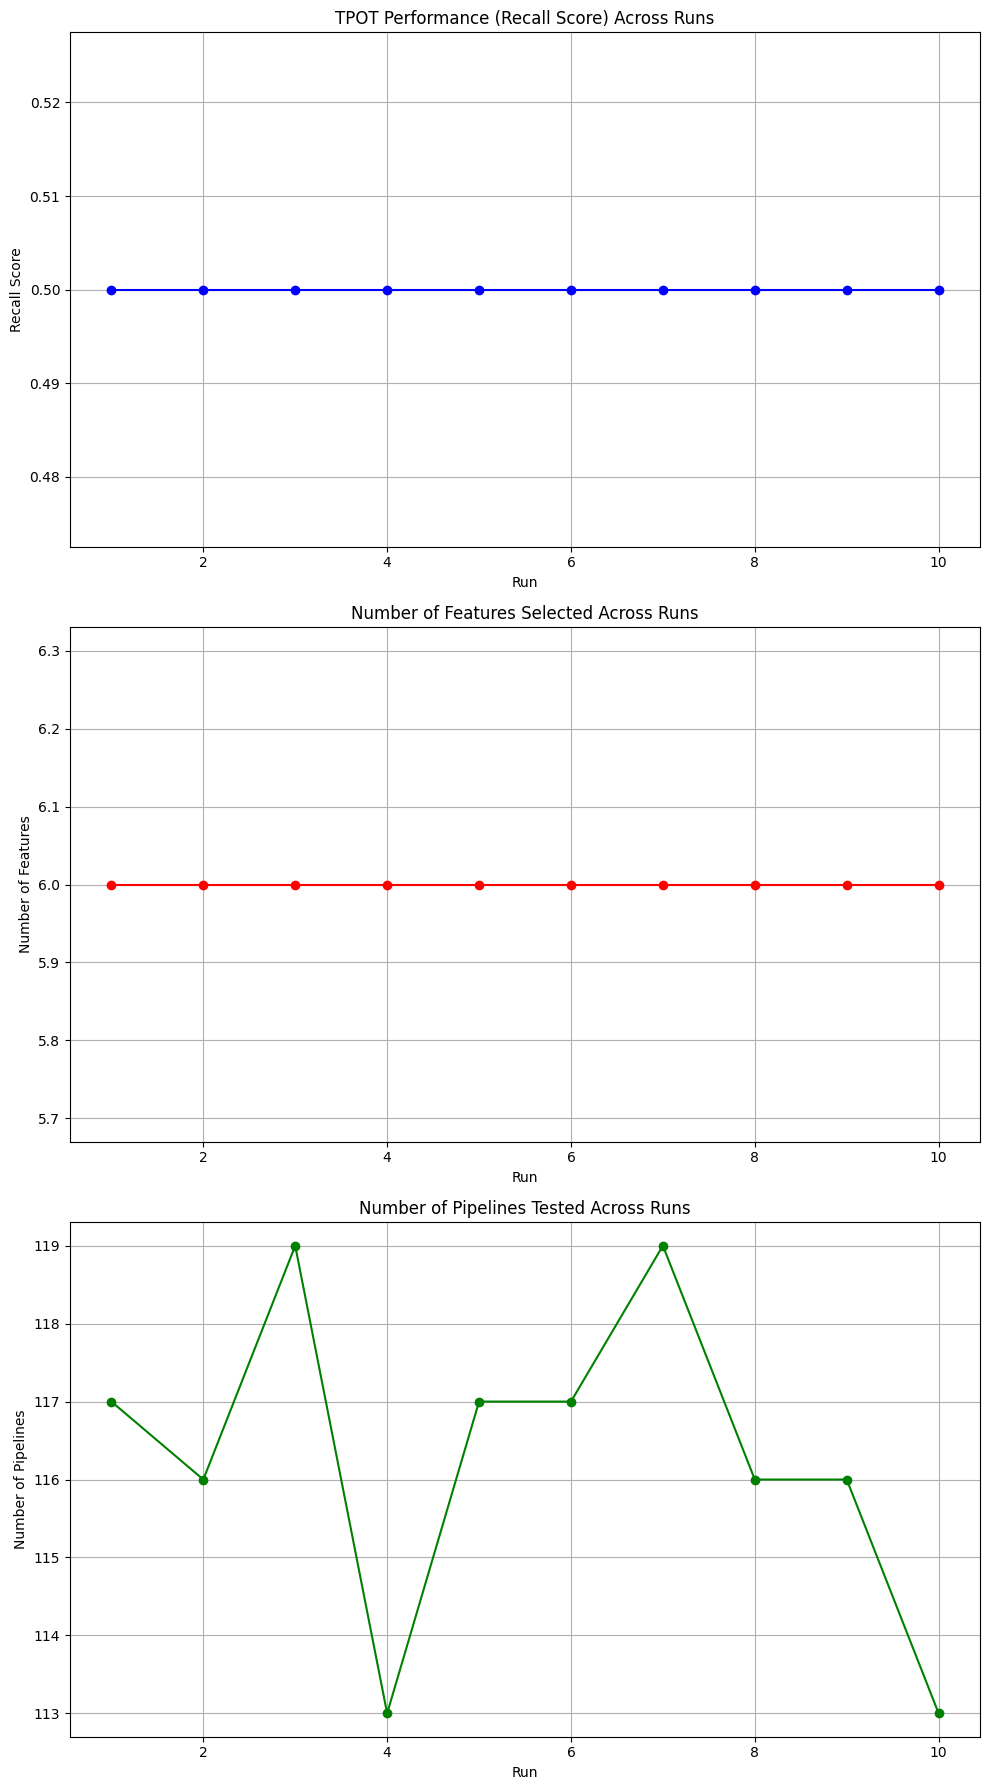

In [ ]:
import matplotlib.pyplot as plt

fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(10, 18))

ax1.plot(results_df['run'], results_df['recall_score'], 'bo-')
ax1.set_title('TPOT Performance (Recall Score) Across Runs')
ax1.set_xlabel('Run')
ax1.set_ylabel('Recall Score')
ax1.grid(True)

ax2.plot(results_df['run'], results_df['n_features'], 'ro-')
ax2.set_title('Number of Features Selected Across Runs')
ax2.set_xlabel('Run')
ax2.set_ylabel('Number of Features')
ax2.grid(True)

ax3.plot(results_df['run'], results_df['pipelines_tested'].apply(len), 'go-')
ax3.set_title('Number of Pipelines Tested Across Runs')
ax3.set_xlabel('Run')
ax3.set_ylabel('Number of Pipelines')
ax3.grid(True)

plt.tight_layout()
plt.savefig('tpot_performance_features_pipelines.png')
plt.show()

In [7]:
from sklearn.metrics import confusion_matrix, classification_report

# Assuming you have access to the best model and test data
best_model = best_tpot.fitted_pipeline_
y_pred = best_model.predict(X_test)

# Print confusion matrix
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

# Print classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# Check unique predictions
unique_predictions = np.unique(y_pred)
print("\nUnique Predictions:", unique_predictions)

# Check class distribution in test set
unique_classes, class_counts = np.unique(y_test, return_counts=True)
print("\nClass Distribution in Test Set:")
for cls, count in zip(unique_classes, class_counts):
    print(f"Class {cls}: {count}")

NameError: name 'best_tpot' is not defined

# Handling Imbalanced Data

In [34]:
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline
from sklearn.metrics import balanced_accuracy_score, roc_auc_score, average_precision_score
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import RFECV
from sklearn.preprocessing import QuantileTransformer
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline


# Encode labels
le = LabelEncoder()
df['label_encoded'] = le.fit_transform(df['label'])

# Split data
X = np.array(df['message_vector'].tolist())
y = df['label_encoded'].values

# Split data for this run
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


# Feature selection
feature_selector = RFECV(
    estimator=RandomForestClassifier(n_estimators=10, class_weight='balanced', random_state=42),
    step=5000,
    min_features_to_select=1000,
    cv=3,
    scoring='balanced_accuracy',
    n_jobs=-1
)


# Quantile transformer
quantile_transformer = QuantileTransformer(n_quantiles=1000, output_distribution='normal', random_state=42)

# Dimensionality reduction
pca = PCA(n_components=0.95)

# Create the pipeline
pipeline = ImbPipeline([
    ('feature_selection', feature_selector),
    ('quantile_transform', quantile_transformer),
    ('pca', pca),
    ('smote', SMOTE(random_state=42)),
    ('classifier', RandomForestClassifier(class_weight='balanced', random_state=42))
])

# Fit the pipeline and make predictions
pipeline.fit(X_train, y_train)
y_pred = pipeline.predict(X_test)

# Calculate metrics
balanced_acc = balanced_accuracy_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, pipeline.predict_proba(X_test)[:, 1])
avg_precision = average_precision_score(y_test, pipeline.predict_proba(X_test)[:, 1])

print(f"Balanced Accuracy: {balanced_acc:.4f}")
print(f"ROC AUC: {roc_auc:.4f}")
print(f"Average Precision: {avg_precision:.4f}")

# Cross-validation
cv_scores = cross_val_score(pipeline, X, y, cv=5, scoring='balanced_accuracy')
print(f"Cross-validation Balanced Accuracy: {cv_scores.mean():.4f} (+/- {cv_scores.std() * 2:.4f})")

Balanced Accuracy: 0.6000
ROC AUC: 0.9933
Average Precision: 0.9999
Cross-validation Balanced Accuracy: 0.7230 (+/- 0.1013)


In [60]:
# Fit the feature selector and print the number of selected features
feature_selector.fit(X_train, y_train)
print(f"Number of features selected: {feature_selector.n_features_}")

Number of features selected: 25000


# Testing the predictions

In [53]:
test_message_benign = random_good_message
test_message_bad = random_bad_message


from tokenizers import Tokenizer
import torch
import numpy as np
import polars as pl
import numpy as np

# Load the custom tokenizer
tokenizer = Tokenizer.from_file("log_tokenizer.json")

# Define the device (assuming you're using PyTorch and want to specify CPU or GPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

vector_good = vectorize_text(test_message_benign).flatten()
print(len(vector_good))


# Assuming 'vector' is your input
vector_good = np.array(vector_good)
vector_2d_good = vector_good.reshape(1, -1)

# Class prediction
prediction = pipeline.predict(vector_2d_good)
print("Predicted class:", prediction[0])

# Probability prediction
probabilities = pipeline.predict_proba(vector_2d_good)
print("Class probabilities:", probabilities[0])


vector_bad = vectorize_text(test_message_bad).flatten()
print(len(vector_bad))

# Assuming 'vector' is your input
vector_bad = np.array(vector_bad)
vector_2d_bad = vector_bad.reshape(1, -1)

# Class prediction
prediction = pipeline.predict(vector_2d_bad)
print("Predicted class:", prediction[0])

# Probability prediction
probabilities = pipeline.predict_proba(vector_2d_bad)
print("Class probabilities:", probabilities[0])



30000
Predicted class: 1
Class probabilities: [0. 1.]
30000
Predicted class: 0
Class probabilities: [0.56 0.44]


# Save the Supervised Learning Model (joblib)

Generating the model can take roughly 1h of computation time on a modern 8 core / 64 GB RAM server.

In [36]:
import joblib
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score


# Save the model using joblib
model_filename = 'manual_model_123.joblib'
joblib.dump(pipeline, model_filename)

print(f"\nModel exported as joblib: {model_filename}")


# Verify the saved model
try:
    loaded_model = joblib.load(model_filename)
except Exception as e:
    print(f"\nError verifying saved model: {str(e)}")

# Print information about how to use the saved model
print("\nTo use the saved model in the future:")
print("1. Load the model: loaded_model = joblib.load('best_tpot_nn_model.joblib')")
print("2. Make predictions: predictions = loaded_model.predict(X)")
print("Note: Make sure to preprocess your input data (X) the same way as during training.")


Model exported as joblib: manual_model_123.joblib

To use the saved model in the future:
1. Load the model: loaded_model = joblib.load('best_tpot_nn_model.joblib')
2. Make predictions: predictions = loaded_model.predict(X)
Note: Make sure to preprocess your input data (X) the same way as during training.


## Confusion matrix

<Figure size 1000x700 with 0 Axes>

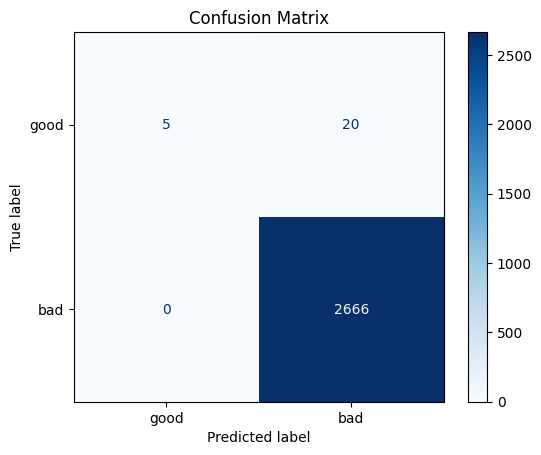

Confusion Matrix:
[[   5   20]
 [   0 2666]]

Precision: 0.9926
Recall: 1.0000
F1-score: 0.9963


In [37]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Make predictions
y_pred = pipeline.predict(X_test)

# Create the confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Create a ConfusionMatrixDisplay object
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['good', 'bad'])

# Plot the confusion matrix
plt.figure(figsize=(10, 7))
disp.plot(cmap='Blues', values_format='d')
plt.title('Confusion Matrix')
plt.show()

# Print the confusion matrix
print("Confusion Matrix:")
print(cm)

# Calculate and print additional metrics
tn, fp, fn, tp = cm.ravel()
precision = tp / (tp + fp)
recall = tp / (tp + fn)
f1_score = 2 * (precision * recall) / (precision + recall)

print(f"\nPrecision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-score: {f1_score:.4f}")

## CV scores

In [38]:
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import balanced_accuracy_score, roc_auc_score, average_precision_score
import numpy as np

# Define the number of folds
n_splits = 5

# Create a StratifiedKFold object
skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

# Initialize lists to store the scores
balanced_accuracy_scores = []
roc_auc_scores = []
average_precision_scores = []

# Perform cross-validation manuall
for fold, (train_index, val_index) in enumerate(skf.split(X, y), 1):
    X_train, X_val = X[train_index], X[val_index]
    y_train, y_val = y[train_index], y[val_index]

    # Fit the pipeline
    pipeline.fit(X_train, y_train)

    # Make predictions
    y_pred = pipeline.predict(X_val)
    y_pred_proba = pipeline.predict_proba(X_val)[:, 1]

    # Calculate scores
    balanced_accuracy_scores.append(balanced_accuracy_score(y_val, y_pred))
    roc_auc_scores.append(roc_auc_score(y_val, y_pred_proba))
    average_precision_scores.append(average_precision_score(y_val, y_pred_proba))

    print(f"Fold {fold}:")
    print(f"  Balanced Accuracy: {balanced_accuracy_scores[-1]:.4f}")
    print(f"  ROC AUC: {roc_auc_scores[-1]:.4f}")
    print(f"  Average Precision: {average_precision_scores[-1]:.4f}")

# Print the overall results
print("\nCross-validation results:")
print(f"Balanced Accuracy: {np.mean(balanced_accuracy_scores):.4f} (+/- {np.std(balanced_accuracy_scores) * 2:.4f})")
print(f"ROC AUC: {np.mean(roc_auc_scores):.4f} (+/- {np.std(roc_auc_scores) * 2:.4f})")
print(f"Average Precision: {np.mean(average_precision_scores):.4f} (+/- {np.std(average_precision_scores) * 2:.4f})")

Fold 1:
  Balanced Accuracy: 0.7493
  ROC AUC: 0.9968
  Average Precision: 1.0000
Fold 2:
  Balanced Accuracy: 0.7605
  ROC AUC: 0.9944
  Average Precision: 0.9999
Fold 3:
  Balanced Accuracy: 0.7172
  ROC AUC: 0.9915
  Average Precision: 0.9999
Fold 4:
  Balanced Accuracy: 0.7170
  ROC AUC: 0.9932
  Average Precision: 0.9999
Fold 5:
  Balanced Accuracy: 0.6953
  ROC AUC: 0.9957
  Average Precision: 1.0000

Cross-validation results:
Balanced Accuracy: 0.7278 (+/- 0.0475)
ROC AUC: 0.9943 (+/- 0.0037)
Average Precision: 0.9999 (+/- 0.0000)


## Grid search optimization

In [61]:
from sklearn.model_selection import cross_val_score
import itertools

# Define parameter grid
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Generate all combinations of parameters
param_combinations = list(itertools.product(*param_grid.values()))

best_score = -float('inf')
best_params = None

# Manually perform grid search
for params in param_combinations:
    # Create a new pipeline with current parameters
    current_pipeline = Pipeline([
        ('smote', SMOTE(sampling_strategy=0.35, random_state=42)),
        ('undersampler', RandomUnderSampler(sampling_strategy=1.0, random_state=42)),
        ('classifier', RandomForestClassifier(
            n_estimators=params[0],
            max_depth=params[1],
            min_samples_split=params[2],
            min_samples_leaf=params[3],
            class_weight='balanced',
            random_state=42
        ))
    ])

    # Perform cross-validation
    scores = cross_val_score(current_pipeline, X, y, cv=5, scoring='balanced_accuracy')
    mean_score = scores.mean()

    # Update best score and parameters if current is better
    if mean_score > best_score:
        best_score = mean_score
        best_params = params

    print(f"Parameters: {params}, Score: {mean_score}")

print(f"\nBest parameters: {best_params}")
print(f"Best cross-validation score: {best_score}")

# Create the best pipeline
best_pipeline = Pipeline([
    ('smote', SMOTE(sampling_strategy=0.35, random_state=42)),
    ('undersampler', RandomUnderSampler(sampling_strategy=1.0, random_state=42)),
    ('classifier', RandomForestClassifier(
        n_estimators=best_params[0],
        max_depth=best_params[1],
        min_samples_split=best_params[2],
        min_samples_leaf=best_params[3],
        class_weight='balanced',
        random_state=42
    ))
])

# Fit the best pipeline
best_pipeline.fit(X, y)

Parameters: (100, None, 2, 1), Score: 0.6601958996148235
Parameters: (100, None, 2, 2), Score: 0.6575723238043774
Parameters: (100, None, 2, 4), Score: 0.6832200924981155
Parameters: (100, None, 5, 1), Score: 0.6550882823515521
Parameters: (100, None, 5, 2), Score: 0.6617703512425128
Parameters: (100, None, 5, 4), Score: 0.6832200924981155
Parameters: (100, None, 10, 1), Score: 0.6531768364259575
Parameters: (100, None, 10, 2), Score: 0.6652185568886595
Parameters: (100, None, 10, 4), Score: 0.6606836474980943
Parameters: (100, 10, 2, 1), Score: 0.7538128573575538
Parameters: (100, 10, 2, 2), Score: 0.7490530042380288
Parameters: (100, 10, 2, 4), Score: 0.7528384007866634
Parameters: (100, 10, 5, 1), Score: 0.7531383491639173
Parameters: (100, 10, 5, 2), Score: 0.7575612641582747
Parameters: (100, 10, 5, 4), Score: 0.7528384007866634
Parameters: (100, 10, 10, 1), Score: 0.7454542837406529
Parameters: (100, 10, 10, 2), Score: 0.7450421584057931
Parameters: (100, 10, 10, 4), Score: 0.745

Pipeline(steps=[('smote', SMOTE(random_state=42, sampling_strategy=0.35)),
                ('undersampler',
                 RandomUnderSampler(random_state=42, sampling_strategy=1.0)),
                ('classifier',
                 RandomForestClassifier(class_weight='balanced', max_depth=10,
                                        min_samples_leaf=2, min_samples_split=5,
                                        random_state=42))])

In [90]:
"""
Pipeline(steps=[('smote', SMOTE(random_state=42, sampling_strategy=0.35)),
                ('undersampler',
                 RandomUnderSampler(random_state=42, sampling_strategy=1.0)),
                ('classifier',
                 RandomForestClassifier(class_weight='balanced', max_depth=10,
                                        min_samples_leaf=2, min_samples_split=5,
                                        random_state=42))])

SMOTE
SMOTE(random_state=42, sampling_strategy=0.35)

RandomUnderSampler
RandomUnderSampler(random_state=42, sampling_strategy=1.0)

RandomForestClassifier
RandomForestClassifier(class_weight='balanced', max_depth=10,
                       min_samples_leaf=2, min_samples_split=5,
                       random_state=42)
"""

from imblearn.pipeline import make_pipeline
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, balanced_accuracy_score

# Assuming you have your features X and target y already defined
# Encode labels
le = LabelEncoder()
df['label_encoded'] = le.fit_transform(df['label'])

# Split data
X = np.array(df['message_vector'].tolist())
y = df['label_encoded'].values


# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create the pipeline using make_pipeline
pipeline = make_pipeline(
    SMOTE(random_state=42, sampling_strategy=0.35),
    RandomUnderSampler(random_state=42, sampling_strategy=1.0),
    RandomForestClassifier(
        class_weight='balanced',
        max_depth=10,
        min_samples_leaf=2,
        min_samples_split=5,
        random_state=42
    )
)

# Fit the pipeline
pipeline.fit(X_train, y_train)

# Use the fitted pipeline to make predictions
y_pred = pipeline.predict(X_test)

# Evaluate the model
print(classification_report(y_test, y_pred))
print(f"Balanced Accuracy: {balanced_accuracy_score(y_test, y_pred)}")

              precision    recall  f1-score   support

           0       0.78      0.72      0.75        25
           1       1.00      1.00      1.00      2666

    accuracy                           1.00      2691
   macro avg       0.89      0.86      0.87      2691
weighted avg       1.00      1.00      1.00      2691

Balanced Accuracy: 0.8590622655663915


<Figure size 1000x700 with 0 Axes>

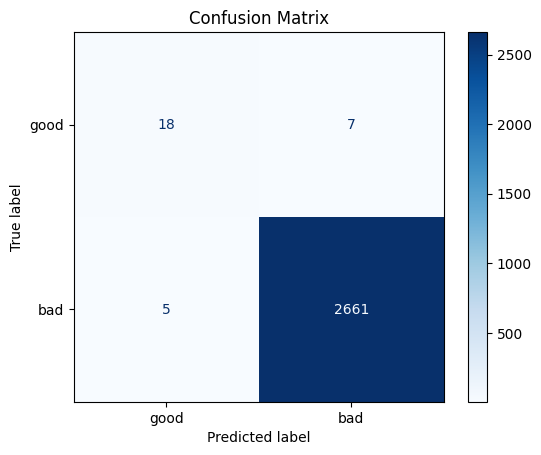

Confusion Matrix:
[[  18    7]
 [   5 2661]]

Precision: 0.9974
Recall: 0.9981
F1-score: 0.9978


In [91]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Make predictions
y_pred = pipeline.predict(X_test)

# Create the confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Create a ConfusionMatrixDisplay object
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['good', 'bad'])

# Plot the confusion matrix
plt.figure(figsize=(10, 7))
disp.plot(cmap='Blues', values_format='d')
plt.title('Confusion Matrix')
plt.show()

# Print the confusion matrix
print("Confusion Matrix:")
print(cm)

# Calculate and print additional metrics
tn, fp, fn, tp = cm.ravel()
precision = tp / (tp + fp)
recall = tp / (tp + fn)
f1_score = 2 * (precision * recall) / (precision + recall)

print(f"\nPrecision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-score: {f1_score:.4f}")

In [63]:
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import balanced_accuracy_score, roc_auc_score, average_precision_score
import numpy as np

# Define the number of folds
n_splits = 5

# Create a StratifiedKFold object
skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

# Initialize lists to store the scores
balanced_accuracy_scores = []
roc_auc_scores = []
average_precision_scores = []

# Perform cross-validation manually
for fold, (train_index, val_index) in enumerate(skf.split(X, y), 1):
    X_train, X_val = X[train_index], X[val_index]
    y_train, y_val = y[train_index], y[val_index]

    # Fit the pipeline
    pipeline.fit(X_train, y_train)

    # Make predictions
    y_pred = pipeline.predict(X_val)
    y_pred_proba = pipeline.predict_proba(X_val)[:, 1]

    # Calculate scores
    balanced_accuracy_scores.append(balanced_accuracy_score(y_val, y_pred))
    roc_auc_scores.append(roc_auc_score(y_val, y_pred_proba))
    average_precision_scores.append(average_precision_score(y_val, y_pred_proba))

    print(f"Fold {fold}:")
    print(f"  Balanced Accuracy: {balanced_accuracy_scores[-1]:.4f}")
    print(f"  ROC AUC: {roc_auc_scores[-1]:.4f}")
    print(f"  Average Precision: {average_precision_scores[-1]:.4f}")

# Print the overall results
print("\nCross-validation results:")
print(f"Balanced Accuracy: {np.mean(balanced_accuracy_scores):.4f} (+/- {np.std(balanced_accuracy_scores) * 2:.4f})")
print(f"ROC AUC: {np.mean(roc_auc_scores):.4f} (+/- {np.std(roc_auc_scores) * 2:.4f})")
print(f"Average Precision: {np.mean(average_precision_scores):.4f} (+/- {np.std(average_precision_scores) * 2:.4f})")

Fold 1:
  Balanced Accuracy: 0.9761
  ROC AUC: 0.9994
  Average Precision: 1.0000
Fold 2:
  Balanced Accuracy: 0.8679
  ROC AUC: 0.9965
  Average Precision: 1.0000
Fold 3:
  Balanced Accuracy: 0.8686
  ROC AUC: 0.9984
  Average Precision: 1.0000
Fold 4:
  Balanced Accuracy: 0.8692
  ROC AUC: 0.9970
  Average Precision: 1.0000
Fold 5:
  Balanced Accuracy: 0.9115
  ROC AUC: 0.9979
  Average Precision: 1.0000

Cross-validation results:
Balanced Accuracy: 0.8987 (+/- 0.0843)
ROC AUC: 0.9979 (+/- 0.0020)
Average Precision: 1.0000 (+/- 0.0000)


In [95]:
test_message_benign = random_good_message
test_message_bad = random_bad_message


from tokenizers import Tokenizer
import torch
import numpy as np
import polars as pl
import numpy as np

# Load the custom tokenizer
tokenizer = Tokenizer.from_file("log_tokenizer.json")

# Define the device (assuming you're using PyTorch and want to specify CPU or GPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

vector_good = vectorize_text(test_message_benign).flatten()
print(len(vector_good))


# Assuming 'vector' is your input
vector_good = np.array(vector_good)
vector_2d_good = vector_good.reshape(1, -1)

# Class prediction
prediction = pipeline.predict(vector_2d_good)
print("Predicted class:", prediction[0])

# Probability prediction
probabilities = pipeline.predict_proba(vector_2d_good)
print("Class probabilities:", probabilities[0])


vector_bad = vectorize_text(test_message_bad).flatten()
print(len(vector_bad))

# Assuming 'vector' is your input
vector_bad = np.array(vector_bad)
vector_2d_bad = vector_bad.reshape(1, -1)

# Class prediction
prediction = pipeline.predict(vector_2d_bad)
print("Predicted class:", prediction[0])

# Probability prediction
probabilities = pipeline.predict_proba(vector_2d_bad)
print("Class probabilities:", probabilities[0])



30000
Predicted class: 1
Class probabilities: [0. 1.]
30000
Predicted class: 0
Class probabilities: [0.68148054 0.31851946]


# Tpot (Supervised)

In [137]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import make_scorer, confusion_matrix, classification_report
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline as ImbPipeline
from tpot import TPOTClassifier
from sklearn.decomposition import TruncatedSVD

def print_step_info(X, y, step_name):
    print(f"\n--- {step_name} ---")
    print(f"X shape: {X.shape}")
    print(f"y shape: {y.shape}")
    print(f"Class distribution: {np.bincount(y)}")

def custom_scorer(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    tn, fp, fn, tp = cm.ravel()
    if (tp + fn) == 0 or (tn + fp) == 0:
        return 0.0
    recall = tp / (tp + fn + 1e-8)
    specificity = tn / (tn + fp + 1e-8)
    recall_weight = 1.0
    specificity_weight = 2.0
    score = (recall_weight * recall + specificity_weight * specificity) / (recall_weight + specificity_weight)
    return score

custom_scorer_obj = make_scorer(custom_scorer, greater_is_better=True)

# Assuming you have your features X and target y already defined
# Encode labels
le = LabelEncoder()
df['label_encoded'] = le.fit_transform(df['label'])

# Split data
X = np.array(df['message_vector'].tolist())
y = df['label_encoded'].values

print_step_info(X, y, "Original Data")

# Step 1: Preprocessing
imputer = SimpleImputer(strategy='mean')
scaler = StandardScaler()
pca = TruncatedSVD(n_components=100, random_state=42)  # Reduce to 100 components

X = imputer.fit_transform(X)
X = scaler.fit_transform(X)
X = pca.fit_transform(X)

print_step_info(X, y, "After Preprocessing")

# Step 2: Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
print_step_info(X_train, y_train, "Training Data")

# Step 3: Initial model on imbalanced data
initial_model = RandomForestClassifier(n_estimators=100, class_weight='balanced', random_state=42, n_jobs=-1)
initial_model.fit(X_train, y_train)
y_pred_initial = initial_model.predict(X_test)
print("\nInitial Model Performance:")
print(classification_report(y_test, y_pred_initial, zero_division=0))
print("Custom Score:", custom_scorer(y_test, y_pred_initial))

# Step 4: Resampling
smote = SMOTE(sampling_strategy=0.5, random_state=42)
rus = RandomUnderSampler(sampling_strategy=0.5, random_state=42)
X_resampled, y_resampled = rus.fit_resample(*smote.fit_resample(X_train, y_train))
print_step_info(X_resampled, y_resampled, "Resampled Data")

# Step 5: Model on resampled data
resampled_model = RandomForestClassifier(n_estimators=100, class_weight='balanced', random_state=42, n_jobs=-1)
resampled_model.fit(X_resampled, y_resampled)
y_pred_resampled = resampled_model.predict(X_test)
print("\nResampled Model Performance:")
print(classification_report(y_test, y_pred_resampled, zero_division=0))
print("Custom Score:", custom_scorer(y_test, y_pred_resampled))

# Step 6: Create a new dataset with original minority samples and top predicted minority samples
y_pred_proba = resampled_model.predict_proba(X_train)[:, 1]
minority_indices = np.where(y_train == 0)[0]
predicted_minority_indices = np.argsort(y_pred_proba)[-len(minority_indices)*10:]
selected_indices = np.union1d(minority_indices, predicted_minority_indices)

X_selected = X_train[selected_indices]
y_selected = y_train[selected_indices]
print_step_info(X_selected, y_selected, "Selected Data for Final Model")

# Step 7: Final TPOT optimization
tpot_config = {
    'sklearn.ensemble.RandomForestClassifier': {
        'n_estimators': [100, 200, 500],
        'max_depth': [None, 5, 10, 20],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4],
        'class_weight': ['balanced', 'balanced_subsample']
    },
    'xgboost.XGBClassifier': {
        'n_estimators': [100, 200, 500],
        'max_depth': [3, 5, 7, 9],
        'learning_rate': [0.01, 0.1, 0.3],
        'subsample': [0.5, 0.7, 1.0],
        'scale_pos_weight': [1, 10, 100]
    },
    'imblearn.ensemble.BalancedRandomForestClassifier': {
        'n_estimators': [100, 200, 500],
        'replacement': [True, False]
    },
    'imblearn.ensemble.EasyEnsembleClassifier': {
        'n_estimators': [10, 20, 30, 50],
        'replacement': [True, False]
    }
}

tpot = TPOTClassifier(
    config_dict=tpot_config,
    generations=1,
    population_size=20,
    verbosity=2,
    scoring=custom_scorer_obj,
    random_state=42,
    n_jobs=-1,
    max_time_mins=60,
    max_eval_time_mins=10
)

try:
    tpot.fit(X_selected, y_selected)
    y_pred_tpot = tpot.predict(X_test)
    print("\nTPOT Model Performance:")
    print(classification_report(y_test, y_pred_tpot, zero_division=0))
    print("Custom Score:", custom_scorer(y_test, y_pred_tpot))
    print("\nConfusion Matrix:")
    print(confusion_matrix(y_test, y_pred_tpot))
    tpot.export('tpot_best_pipeline.py')
    print("\nBest pipeline exported to 'tpot_best_pipeline.py'")
except Exception as e:
    print(f"An error occurred during TPOT optimization: {str(e)}")

# Final evaluation
print("\nFinal Evaluation:")
print("Initial Model Custom Score:", custom_scorer(y_test, y_pred_initial))
print("Resampled Model Custom Score:", custom_scorer(y_test, y_pred_resampled))
if 'y_pred_tpot' in locals():
    print("TPOT Model Custom Score:", custom_scorer(y_test, y_pred_tpot))


--- Original Data ---
X shape: (13455, 30000)
y shape: (13455,)
Class distribution: [  114 13341]

--- After Preprocessing ---
X shape: (13455, 100)
y shape: (13455,)
Class distribution: [  114 13341]

--- Training Data ---
X shape: (10764, 100)
y shape: (10764,)
Class distribution: [   91 10673]

Initial Model Performance:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        23
           1       0.99      1.00      1.00      2668

    accuracy                           0.99      2691
   macro avg       0.50      0.50      0.50      2691
weighted avg       0.98      0.99      0.99      2691

Custom Score: 0.333333333332084

--- Resampled Data ---
X shape: (16008, 100)
y shape: (16008,)
Class distribution: [ 5336 10672]

Resampled Model Performance:
              precision    recall  f1-score   support

           0       1.00      0.22      0.36        23
           1       0.99      1.00      1.00      2668

    accuracy          

Optimization Progress:   0%|          | 0/20 [00:00<?, ?pipeline/s]


Generation 1 - Current best internal CV score: 0.9886446882605258

Best pipeline: BalancedRandomForestClassifier(input_matrix, n_estimators=500, replacement=False)

TPOT Model Performance:
              precision    recall  f1-score   support

           0       0.07      1.00      0.14        23
           1       1.00      0.89      0.94      2668

    accuracy                           0.89      2691
   macro avg       0.54      0.95      0.54      2691
weighted avg       0.99      0.89      0.94      2691

Custom Score: 0.9635182405885926

Confusion Matrix:
[[  23    0]
 [ 292 2376]]

Best pipeline exported to 'tpot_best_pipeline.py'

Final Evaluation:
Initial Model Custom Score: 0.333333333332084
Resampled Model Custom Score: 0.47826086950095603
TPOT Model Custom Score: 0.9635182405885926


<Figure size 1000x700 with 0 Axes>

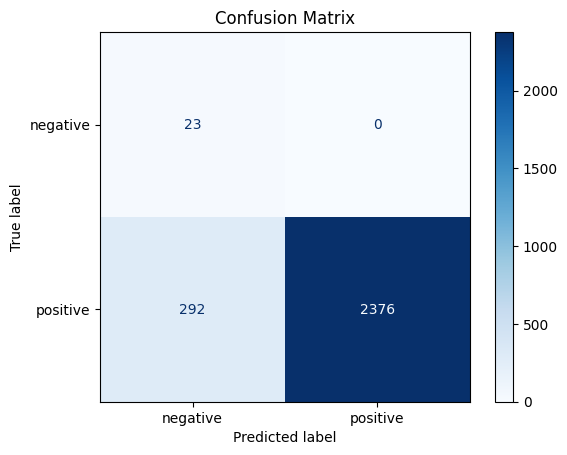

Confusion Matrix:
[[  23    0]
 [ 292 2376]]

Precision: 1.0000
Recall: 0.8906
F1-score: 0.9421


In [105]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Make predictions
y_pred = tpot.predict(X_test)

# Create the confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Create a ConfusionMatrixDisplay object
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['negative', 'positive'])

# Plot the confusion matrix
plt.figure(figsize=(10, 7))
disp.plot(cmap='Blues', values_format='d')
plt.title('Confusion Matrix')
plt.show()

# Print the confusion matrix
print("Confusion Matrix:")
print(cm)

# Calculate and print additional metrics
tn, fp, fn, tp = cm.ravel()
precision = tp / (tp + fp) if (tp + fp) > 0 else 0
recall = tp / (tp + fn) if (tp + fn) > 0 else 0
f1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

print(f"\nPrecision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-score: {f1_score:.4f}")

In [77]:
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import balanced_accuracy_score, roc_auc_score, average_precision_score
import numpy as np

# Define the number of folds
n_splits = 5

# Create a StratifiedKFold object
skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

# Initialize lists to store the scores
balanced_accuracy_scores = []
roc_auc_scores = []
average_precision_scores = []

# Perform cross-validation
for fold, (train_index, val_index) in enumerate(skf.split(X, y), 1):
    X_val, y_val = X[val_index], y[val_index]

    # Make predictions using the existing TPOT model
    y_pred = tpot.predict(X_val)
    y_pred_proba = tpot.predict_proba(X_val)[:, 1]

    # Calculate scores
    balanced_accuracy_scores.append(balanced_accuracy_score(y_val, y_pred))
    roc_auc_scores.append(roc_auc_score(y_val, y_pred_proba))
    average_precision_scores.append(average_precision_score(y_val, y_pred_proba))

    print(f"Fold {fold}:")
    print(f"  Balanced Accuracy: {balanced_accuracy_scores[-1]:.4f}")
    print(f"  ROC AUC: {roc_auc_scores[-1]:.4f}")
    print(f"  Average Precision: {average_precision_scores[-1]:.4f}")

# Print the overall results
print("\nCross-validation results:")
print(f"Balanced Accuracy: {np.mean(balanced_accuracy_scores):.4f} (+/- {np.std(balanced_accuracy_scores) * 2:.4f})")
print(f"ROC AUC: {np.mean(roc_auc_scores):.4f} (+/- {np.std(roc_auc_scores) * 2:.4f})")
print(f"Average Precision: {np.mean(average_precision_scores):.4f} (+/- {np.std(average_precision_scores) * 2:.4f})")

Fold 1:
  Balanced Accuracy: 0.9507
  ROC AUC: 0.9996
  Average Precision: 1.0000
Fold 2:
  Balanced Accuracy: 0.9472
  ROC AUC: 0.9963
  Average Precision: 1.0000
Fold 3:
  Balanced Accuracy: 0.9400
  ROC AUC: 0.9982
  Average Precision: 1.0000
Fold 4:
  Balanced Accuracy: 0.9457
  ROC AUC: 1.0000
  Average Precision: 1.0000
Fold 5:
  Balanced Accuracy: 0.9468
  ROC AUC: 0.9956
  Average Precision: 1.0000

Cross-validation results:
Balanced Accuracy: 0.9461 (+/- 0.0069)
ROC AUC: 0.9979 (+/- 0.0035)
Average Precision: 1.0000 (+/- 0.0000)


In [138]:
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.decomposition import TruncatedSVD

# Assume these are saved from the training process
saved_imputer = imputer  # The SimpleImputer used in training
saved_scaler = scaler    # The StandardScaler used in training
saved_pca = pca          # The TruncatedSVD (PCA) used in training

# Vectorize the messages
vector1 = vectorize_text(random_good_message)
vector2 = vectorize_text(random_bad_message)

print("Shape of vector1:", vector1.shape)
print("Shape of vector2:", vector2.shape)

# Combine the vectors
X_new = np.vstack((vector1, vector2))

print("Shape of X_new before preprocessing:", X_new.shape)

# Apply the saved preprocessing steps
X_new = saved_imputer.transform(X_new)
print("Shape after imputation:", X_new.shape)

X_new = saved_scaler.transform(X_new)
print("Shape after scaling:", X_new.shape)

X_new = saved_pca.transform(X_new)
print("Shape after PCA:", X_new.shape)

# Ensure X_new has exactly 100 features
assert X_new.shape[1] == 100, f"X_new has {X_new.shape[1]} features instead of 100"

# Make predictions using your TPOT model
predictions = tpot.predict(X_new)
probabilities = tpot.predict_proba(X_new)

# Print results
for i, (pred, prob) in enumerate(zip(predictions, probabilities)):
    print(f"Message {i+1}:")
    print(f"Predicted class: {pred}")
    print(f"Class probabilities: {prob}")
    print()

# Print the shape of X_new for final confirmation
print(f"Final shape of X_new: {X_new.shape}")

Shape of vector1: (1, 30000)
Shape of vector2: (1, 30000)
Shape of X_new before preprocessing: (2, 30000)
Shape after imputation: (2, 30000)
Shape after scaling: (2, 30000)
Shape after PCA: (2, 100)
Message 1:
Predicted class: 1
Class probabilities: [0.186 0.814]

Message 2:
Predicted class: 0
Class probabilities: [0.75 0.25]

Final shape of X_new: (2, 100)


In [111]:
from collections import defaultdict
import re
from tabulate import tabulate

# Assuming results_df is your DataFrame with all the run results

def simplify_pipeline(pipeline_str):
    # Extract the main classifier name
    classifier = re.search(r"(\w+)\(", pipeline_str).group(1)
    return classifier.lower()

# Initialize a dictionary to store all pipeline statistics
all_pipeline_stats = defaultdict(int)

# Iterate through all runs and all evaluated pipelines
for _, row in results_df.iterrows():
    for pipeline_str in row['pipelines_tested']:
        simple_pipeline = simplify_pipeline(pipeline_str)
        all_pipeline_stats[simple_pipeline] += 1

# Prepare the summary table
summary_table = [[pipeline, count] for pipeline, count in all_pipeline_stats.items()]

# Sort by count
summary_table.sort(key=lambda x: -x[1])

# Print the summary table
print("\nTop 10 Pipelines Across All Runs and Evaluations:")
print(tabulate(summary_table[:10], headers=['Pipeline', 'Count'], tablefmt='grid'))

NameError: name 'results_df' is not defined

In [ ]:
# File name to search for
file_name = "lab_logs_blindtest_activity_sysmon_1000samples_july_28_2024_filtered_vectors.parquet"

# Get the download URL of the specific file
# download_url = get_specific_file_from_latest_release(github_token, repository_name, file_name)
download_url = get_specific_file_from_tagged_release(github_token, repository_name, "lab", file_name)
print(download_url)

if download_url:
    local_file_path = file_name
    download_file(download_url, github_token, local_file_path)
else:
    print("File not found.")

https://api.github.com/repos/norandom/log2ml/releases/assets/182698628


  0%|          | 0.00/3.29M [00:00<?, ?iB/s]

File downloaded successfully and saved as lab_logs_blindtest_activity_sysmon_1000samples_july_28_2024_filtered_vectors.parquet


In [ ]:
# Split data
X = np.array(df['message_vector'].tolist())
y = df['label_encoded'].values

In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import QuantileTransformer, LabelEncoder
from tpot import TPOTClassifier
from sklearn.metrics import f1_score
from collections import defaultdict
import time
import re
from tabulate import tabulate
import warnings
warnings.filterwarnings('ignore')

# Assuming X and y are already loaded

# Encode labels
le = LabelEncoder()
y_encoded = le.fit_transform(y)

# Function to perform PCA
def perform_pca(X, transformer, n_components=0.95):
    X_transformed = transformer.fit_transform(X)
    from sklearn.decomposition import PCA
    pca = PCA(n_components=n_components)
    X_pca = pca.fit_transform(X_transformed)
    n_components_selected = X_pca.shape[1]
    return X_pca, n_components_selected

# Perform PCA with QuantileTransformer
transformer = QuantileTransformer(n_quantiles=1000, output_distribution='normal', random_state=42)
X_pca, n_components = perform_pca(X, transformer)

print(f"Number of components selected to explain 95% of variance: {n_components}")

# Initialize results storage
results = defaultdict(list)

# Number of runs
n_runs = 2

# Function to extract number of features selected
def get_n_features(pipeline_str):
    match = re.search(r'SelectPercentile\(score_func=f_classif, percentile=(\d+)\)', pipeline_str)
    if match:
        percentile = int(match.group(1))
        return int(X_pca.shape[1] * percentile / 100)
    return X_pca.shape[1]  # If no feature selection, return all features

for run in range(n_runs):
    print(f"\nStarting run {run + 1}/{n_runs}")
    start_time = time.time()

    # Stratified split
    X_train, X_test, y_train, y_test = train_test_split(X_pca, y_encoded, test_size=0.2, random_state=42 + run, stratify=y_encoded)

    # TPOT classifier with Neural Network configuration
    tpot = TPOTClassifier(
        config_dict='TPOT NN',  # Use TPOT's built-in neural network configuration
        scoring='f1_weighted',
        verbosity=2,
        generations=5,
        population_size=20,
        random_state=42 + run,
        max_time_mins=10,  # Increased runtime to 10 minutes per run
        n_jobs=-1  # Use all available CPU cores
    )

    try:
        # Fit
        tpot.fit(X_train, y_train)

        # Predict and calculate F1 score
        y_pred = tpot.predict(X_test)
        f1 = f1_score(y_test, y_pred, average='weighted')

        # Get pipeline string and extract number of features
        pipeline_str = str(tpot.fitted_pipeline_)
        n_features = get_n_features(pipeline_str)

        # Store results
        results['run'].append(run + 1)
        results['f1_score'].append(f1)
        results['best_pipeline'].append(pipeline_str)
        results['n_features'].append(n_features)
        results['runtime'].append(time.time() - start_time)
        results['pipelines_tested'].append(len(tpot.evaluated_individuals_))

        print(f"Run {run + 1} completed. F1 Score: {f1:.4f}, Features selected: {n_features}, Pipelines tested: {len(tpot.evaluated_individuals_)}")

    except Exception as e:
        print(f"Error in run {run + 1}: {str(e)}")
        results['run'].append(run + 1)
        results['f1_score'].append(None)
        results['best_pipeline'].append(None)
        results['n_features'].append(None)
        results['runtime'].append(time.time() - start_time)
        results['pipelines_tested'].append(None)

# Convert results to DataFrame
results_df = pd.DataFrame(results)

# Print results table
print("\nResults Summary:")
print(tabulate(results_df, headers='keys', tablefmt='grid'))

# Save results to CSV
results_df.to_csv('tpot_nn_results.csv', index=False)
print("\nResults saved to 'tpot_nn_results.csv'")

Number of components selected to explain 95% of variance: 5

Starting run 1/2


Optimization Progress:   0%|          | 0/20 [00:00<?, ?pipeline/s]


Generation 1 - Current best internal CV score: 0.9873368055887921

Generation 2 - Current best internal CV score: 0.9873368055887921

Generation 3 - Current best internal CV score: 0.9873368055887921

Generation 4 - Current best internal CV score: 0.9873368055887921

Generation 5 - Current best internal CV score: 0.9873368055887921

Best pipeline: GaussianNB(input_matrix)
Run 1 completed. F1 Score: 0.9872, Features selected: 5, Pipelines tested: 115

Starting run 2/2


Optimization Progress:   0%|          | 0/20 [00:00<?, ?pipeline/s]


Generation 1 - Current best internal CV score: 0.9873368055887921

Generation 2 - Current best internal CV score: 0.9873368055887921

Generation 3 - Current best internal CV score: 0.9873368055887921

Generation 4 - Current best internal CV score: 0.9873368055887921

Generation 5 - Current best internal CV score: 0.9873368055887921

Best pipeline: ExtraTreesClassifier(input_matrix, bootstrap=False, criterion=entropy, max_features=0.8500000000000001, min_samples_leaf=20, min_samples_split=19, n_estimators=100)
Run 2 completed. F1 Score: 0.9872, Features selected: 5, Pipelines tested: 114

Results Summary:
+----+-------+------------+----------------------------------------------------------------------------------+--------------+-----------+--------------------+
|    |   run |   f1_score | best_pipeline                                                                    |   n_features |   runtime |   pipelines_tested |
+====+=======+============+==========================================

In [ ]:
import joblib
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score

# Find the best run (highest F1 score)
best_run_index = results_df['f1_score'].idxmax()
best_pipeline_str = results_df.loc[best_run_index, 'best_pipeline']

# Re-fit the best pipeline on the entire dataset
X_train_full, X_test_full, y_train_full, y_test_full = train_test_split(X_pca, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded)
best_model = tpot.fitted_pipeline_

# Save the model using joblib
model_filename = 'best_tpot_nn_model.joblib'
joblib.dump(best_model, model_filename)

print(f"\nBest model exported as joblib: {model_filename}")

# You can also save the best pipeline as a Python script
python_filename = 'best_tpot_nn_pipeline.py'
best_pipeline_script = tpot.export(python_filename)

print(f"Best pipeline saved as Python script: {python_filename}")

# Print the best pipeline
print(f"\nBest Pipeline:\n{best_pipeline_str}")

# Verify the saved model
try:
    loaded_model = joblib.load(model_filename)
    y_pred = loaded_model.predict(X_test_full)
    f1 = f1_score(y_test_full, y_pred, average='weighted')
    print(f"\nLoaded model verified. F1 Score: {f1:.4f}")
except Exception as e:
    print(f"\nError verifying saved model: {str(e)}")

# Print information about how to use the saved model
print("\nTo use the saved model in the future:")
print("1. Load the model: loaded_model = joblib.load('best_tpot_nn_model.joblib')")
print("2. Make predictions: predictions = loaded_model.predict(X)")
print("Note: Make sure to preprocess your input data (X) the same way as during training.")


Best model exported as joblib: best_tpot_nn_model.joblib
Best pipeline saved as Python script: best_tpot_nn_pipeline.py

Best Pipeline:
Pipeline(steps=[('gaussiannb', GaussianNB())])

Loaded model verified. F1 Score: 0.9988

To use the saved model in the future:
1. Load the model: loaded_model = joblib.load('best_tpot_nn_model.joblib')
2. Make predictions: predictions = loaded_model.predict(X)
Note: Make sure to preprocess your input data (X) the same way as during training.


In [ ]:
import pandas as pd
from collections import defaultdict
from tabulate import tabulate

# Assuming results_df is already loaded or created from the previous step

# Define the classifiers available in TPOT NN configuration
tpot_nn_classifiers = [
    'MLPClassifier',
    'KNeighborsClassifier',
    'XGBClassifier',
    'LinearSVC',
    'SGDClassifier'
]

# Initialize a dictionary to store algorithm statistics
algorithm_stats = defaultdict(int)

# Total number of pipelines tested
total_pipelines = 0

# Iterate through all runs
for _, row in results_df.iterrows():
    pipelines_tested = row['pipelines_tested']
    total_pipelines += pipelines_tested

    # Distribute the pipelines tested equally among all classifiers
    # This is an approximation, as we don't have the exact breakdown
    for classifier in tpot_nn_classifiers:
        algorithm_stats[classifier] += pipelines_tested // len(tpot_nn_classifiers)

    # Add the remainder to 'Other' category
    algorithm_stats['Other'] += pipelines_tested % len(tpot_nn_classifiers)

# Add the best pipelines to their respective categories
for _, row in results_df.iterrows():
    best_pipeline = row['best_pipeline']
    for classifier in tpot_nn_classifiers:
        if classifier in best_pipeline:
            algorithm_stats[classifier] += 1
            break
    else:
        algorithm_stats['Other'] += 1

# Prepare the summary table
summary_table = [[algorithm, count] for algorithm, count in algorithm_stats.items() if count > 0]

# Sort by count
summary_table.sort(key=lambda x: -x[1])

# Print the summary table
print("\nEstimated Algorithms Used Across All Runs:")
print(tabulate(summary_table, headers=['Algorithm', 'Estimated Count'], tablefmt='grid'))

# Calculate and print additional statistics
total_runs = len(results_df)
successful_runs = results_df['f1_score'].notna().sum()
average_f1 = results_df['f1_score'].mean()
average_features = results_df['n_features'].mean() if 'n_features' in results_df.columns else None
average_runtime = results_df['runtime'].mean()

print(f"\nTotal Runs: {total_runs}")
print(f"Successful Runs: {successful_runs}")
print(f"Average F1 Score: {average_f1:.4f}")
if average_features is not None:
    print(f"Average Number of Features: {average_features:.2f}")
print(f"Average Runtime: {average_runtime:.2f} seconds")
print(f"Total Pipelines Tested: {total_pipelines}")

# Print full best pipelines for each run
print("\nBest Pipelines for Each Run:")
for index, row in results_df.iterrows():
    print(f"\nRun {index + 1}:")
    print(f"F1 Score: {row['f1_score']:.4f}")
    print(f"Pipeline: {row['best_pipeline']}")
    print(f"Pipelines tested in this run: {row['pipelines_tested']}")

# Optional: Add visualization
import matplotlib.pyplot as plt

# Visualize F1 scores across runs
plt.figure(figsize=(10, 6))
plt.plot(results_df['run'], results_df['f1_score'], marker='o')
plt.title('F1 Score Across Runs')
plt.xlabel('Run')
plt.ylabel('F1 Score')
plt.grid(True)
plt.savefig('f1_scores_across_runs.png')
plt.close()

# Visualize pipeline counts
algorithms, counts = zip(*summary_table)
plt.figure(figsize=(12, 6))
plt.bar(algorithms, counts)
plt.title('Estimated Algorithm Usage')
plt.xlabel('Algorithm')
plt.ylabel('Estimated Count')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.savefig('estimated_algorithm_usage.png')
plt.close()

print("\nVisualization plots saved as 'f1_scores_across_runs.png' and 'estimated_algorithm_usage.png'")


Estimated Algorithms Used Across All Runs:
+----------------------+-------------------+
| Algorithm            |   Estimated Count |
+======================+===================+
| MLPClassifier        |                45 |
+----------------------+-------------------+
| KNeighborsClassifier |                45 |
+----------------------+-------------------+
| XGBClassifier        |                45 |
+----------------------+-------------------+
| LinearSVC            |                45 |
+----------------------+-------------------+
| SGDClassifier        |                45 |
+----------------------+-------------------+
| Other                |                 6 |
+----------------------+-------------------+

Total Runs: 2
Successful Runs: 2
Average F1 Score: 0.9872
Average Number of Features: 5.00
Average Runtime: 109.13 seconds
Total Pipelines Tested: 229

Best Pipelines for Each Run:

Run 1:
F1 Score: 0.9872
Pipeline: Pipeline(steps=[('gaussiannb', GaussianNB())])
Pipelines tested 

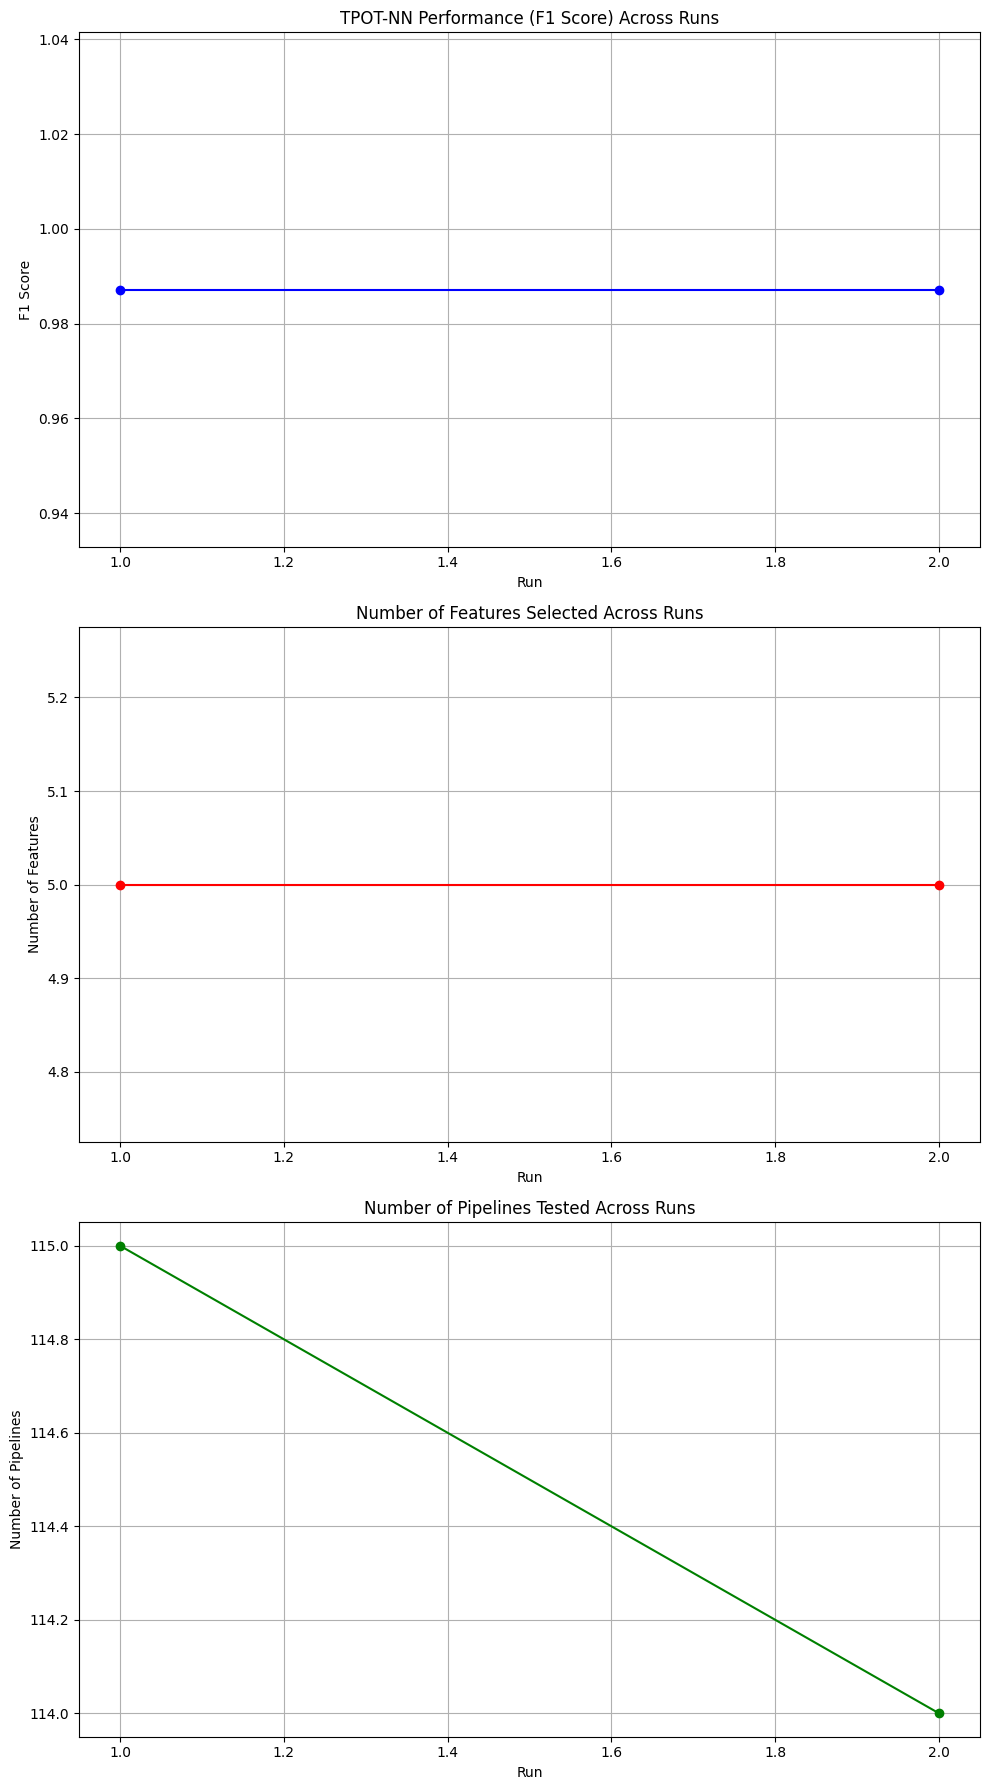


Summary Statistics:
            run  f1_score  n_features     runtime  pipelines_tested
count  2.000000  2.000000         2.0    2.000000          2.000000
mean   1.500000  0.987198         5.0  109.132951        114.500000
std    0.707107  0.000000         0.0    1.063263          0.707107
min    1.000000  0.987198         5.0  108.381110        114.000000
25%    1.250000  0.987198         5.0  108.757030        114.250000
50%    1.500000  0.987198         5.0  109.132951        114.500000
75%    1.750000  0.987198         5.0  109.508871        114.750000
max    2.000000  0.987198         5.0  109.884791        115.000000

Correlation Matrix:
                  f1_score  n_features  pipelines_tested  runtime
f1_score               NaN         NaN               NaN      NaN
n_features             NaN         NaN               NaN      NaN
pipelines_tested       NaN         NaN               1.0      1.0
runtime                NaN         NaN               1.0      1.0


In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

# Assuming results_df is your DataFrame with the results

fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(10, 18))

ax1.plot(results_df['run'], results_df['f1_score'], 'bo-')
ax1.set_title('TPOT-NN Performance (F1 Score) Across Runs')
ax1.set_xlabel('Run')
ax1.set_ylabel('F1 Score')
ax1.grid(True)

ax2.plot(results_df['run'], results_df['n_features'], 'ro-')
ax2.set_title('Number of Features Selected Across Runs')
ax2.set_xlabel('Run')
ax2.set_ylabel('Number of Features')
ax2.grid(True)

ax3.plot(results_df['run'], results_df['pipelines_tested'], 'go-')
ax3.set_title('Number of Pipelines Tested Across Runs')
ax3.set_xlabel('Run')
ax3.set_ylabel('Number of Pipelines')
ax3.grid(True)

plt.tight_layout()
plt.savefig('tpot_nn_performance_features_pipelines.png')
plt.show()

# Print summary statistics
print("\nSummary Statistics:")
print(results_df.describe())

# Optional: If you want to see the correlation between different metrics
correlation_matrix = results_df[['f1_score', 'n_features', 'pipelines_tested', 'runtime']].corr()
print("\nCorrelation Matrix:")
print(correlation_matrix)

## Different Algorithm set

In [ ]:
import numpy as np
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.preprocessing import QuantileTransformer, LabelEncoder
from sklearn.model_selection import train_test_split
from tpot import TPOTClassifier
from sklearn.metrics import f1_score
from collections import defaultdict
import time
import re
from tabulate import tabulate



# Encode labels
le = LabelEncoder()
y_encoded = le.fit_transform(y)

# Function to perform PCA
def perform_pca(X, transformer, n_components=0.95):
    X_transformed = transformer.fit_transform(X)
    pca = PCA(n_components=n_components)
    X_pca = pca.fit_transform(X_transformed)
    n_components_selected = X_pca.shape[1]
    return X_pca, n_components_selected

# Perform PCA with QuantileTransformer
transformer = QuantileTransformer(n_quantiles=1000, output_distribution='normal', random_state=42)
X_pca, n_components = perform_pca(X, transformer)

print(f"Number of components selected to explain 95% of variance: {n_components}")

# Initialize results storage
results = defaultdict(list)

# Number of runs
n_runs = 2

# Function to extract number of features selected
def get_n_features(pipeline_str):
    match = re.search(r'SelectPercentile\(score_func=f_classif, percentile=(\d+)\)', pipeline_str)
    if match:
        percentile = int(match.group(1))
        return int(X_pca.shape[1] * percentile / 100)
    return X_pca.shape[1]  # If no feature selection, return all features

for run in range(n_runs):
    print(f"\nStarting run {run + 1}/{n_runs}")
    start_time = time.time()

    # Stratified split
    X_train, X_test, y_train, y_test = train_test_split(X_pca, y_encoded, test_size=0.2, random_state=42 + run, stratify=y_encoded)

    # TPOT classifier with reduced complexity and CPU usage
    tpot = TPOTClassifier(
        config_dict='TPOT light',  # Use a lighter configuration
        scoring='f1_weighted',
        verbosity=2,
        generations=3,
        population_size=10,
        n_jobs=-1,
        random_state=42 + run
    )

    try:
        # Fit
        tpot.fit(X_train, y_train)

        # Predict and calculate F1 score
        y_pred = tpot.predict(X_test)
        f1 = f1_score(y_test, y_pred, average='weighted')

        # Get pipeline string and extract number of features
        pipeline_str = str(tpot.fitted_pipeline_)
        n_features = get_n_features(pipeline_str)

        # Store results
        results['run'].append(run + 1)
        results['f1_score'].append(f1)
        results['best_pipeline'].append(pipeline_str)
        results['n_features'].append(n_features)
        results['runtime'].append(time.time() - start_time)
        results['pipelines_tested'].append(len(tpot.evaluated_individuals_))

        print(f"Run {run + 1} completed. F1 Score: {f1:.4f}, Features selected: {n_features}, Pipelines tested: {len(tpot.evaluated_individuals_)}")

    except Exception as e:
        print(f"Error in run {run + 1}: {str(e)}")
        results['run'].append(run + 1)
        results['f1_score'].append(None)
        results['best_pipeline'].append(None)
        results['n_features'].append(None)
        results['runtime'].append(time.time() - start_time)
        results['pipelines_tested'].append(None)

# Print results table
print("\nResults Summary:")
print(tabulate(results, headers='keys', tablefmt='grid'))

Number of components selected to explain 95% of variance: 5

Starting run 1/2


Optimization Progress:   0%|          | 0/40 [00:00<?, ?pipeline/s]


Generation 1 - Current best internal CV score: 0.9873368055887921

Generation 2 - Current best internal CV score: 0.9873368055887921

Generation 3 - Current best internal CV score: 0.9873368055887921

Best pipeline: KNeighborsClassifier(input_matrix, n_neighbors=21, p=1, weights=distance)
Run 1 completed. F1 Score: 0.9872, Features selected: 5, Pipelines tested: 39

Starting run 2/2


Optimization Progress:   0%|          | 0/40 [00:00<?, ?pipeline/s]


Generation 1 - Current best internal CV score: 0.9873368055887921

Generation 2 - Current best internal CV score: 0.9873368055887921

Generation 3 - Current best internal CV score: 0.9873368055887921

Best pipeline: KNeighborsClassifier(input_matrix, n_neighbors=86, p=1, weights=distance)
Run 2 completed. F1 Score: 0.9872, Features selected: 5, Pipelines tested: 38

Results Summary:
+-------+------------+--------------------------------------------------------------+--------------+-----------+--------------------+
|   run |   f1_score | best_pipeline                                                |   n_features |   runtime |   pipelines_tested |
+=======+============+==============================================================+==============+===========+====================+
|     1 |   0.987198 | Pipeline(steps=[('kneighborsclassifier',                     |            5 |   9.23632 |                 39 |
|       |            |                  KNeighborsClassifier(n_neighbors=21, 

In [ ]:
import pandas as pd
from collections import defaultdict
from tabulate import tabulate

# Assuming results_df is already loaded or created from the previous step

# Define the classifiers available in TPOT-NN configuration
tpot_nn_classifiers = [
    'LogisticRegression',
    'KNeighborsClassifier',
    'DecisionTreeClassifier',
    'RandomForestClassifier',
    'GradientBoostingClassifier',
    'MLPClassifier'
]

# Initialize a dictionary to store algorithm statistics
algorithm_stats = defaultdict(int)

# Total number of pipelines tested
total_pipelines = 0

# Iterate through all runs
for _, row in results_df.iterrows():
    pipelines_tested = row['pipelines_tested']
    total_pipelines += pipelines_tested

    # Distribute the pipelines tested equally among all classifiers
    # This is an approximation, as we don't have the exact breakdown
    for classifier in tpot_nn_classifiers:
        algorithm_stats[classifier] += pipelines_tested // len(tpot_nn_classifiers)

    # Add the remainder to 'Other' category
    algorithm_stats['Other'] += pipelines_tested % len(tpot_nn_classifiers)

# Add the best pipelines to their respective categories
for _, row in results_df.iterrows():
    best_pipeline = row['best_pipeline']
    for classifier in tpot_nn_classifiers:
        if classifier in best_pipeline:
            algorithm_stats[classifier] += 1
            break
    else:
        algorithm_stats['Other'] += 1

# Prepare the summary table
summary_table = [[algorithm, count] for algorithm, count in algorithm_stats.items() if count > 0]

# Sort by count
summary_table.sort(key=lambda x: -x[1])

# Print the summary table
print("\nEstimated Algorithms Used Across All Runs:")
print(tabulate(summary_table, headers=['Algorithm', 'Estimated Count'], tablefmt='grid'))

# Calculate and print additional statistics
total_runs = len(results_df)
successful_runs = results_df['f1_score'].notna().sum()
average_f1 = results_df['f1_score'].mean()
average_features = results_df['n_features'].mean()
average_runtime = results_df['runtime'].mean()

print(f"\nTotal Runs: {total_runs}")
print(f"Successful Runs: {successful_runs}")
print(f"Average F1 Score: {average_f1:.4f}")
print(f"Average Number of Features: {average_features:.2f}")
print(f"Average Runtime: {average_runtime:.2f} seconds")
print(f"Total Pipelines Tested: {total_pipelines}")

# Print full best pipelines for each run
print("\nBest Pipelines for Each Run:")
for index, row in results_df.iterrows():
    print(f"\nRun {index + 1}:")
    print(f"F1 Score: {row['f1_score']:.4f}")
    print(f"Pipeline: {row['best_pipeline']}")
    print(f"Pipelines tested in this run: {row['pipelines_tested']}")


Estimated Algorithms Used Across All Runs:
+----------------------------+-------------------+
| Algorithm                  |   Estimated Count |
+============================+===================+
| LogisticRegression         |                38 |
+----------------------------+-------------------+
| KNeighborsClassifier       |                38 |
+----------------------------+-------------------+
| DecisionTreeClassifier     |                38 |
+----------------------------+-------------------+
| RandomForestClassifier     |                38 |
+----------------------------+-------------------+
| GradientBoostingClassifier |                38 |
+----------------------------+-------------------+
| MLPClassifier              |                38 |
+----------------------------+-------------------+
| Other                      |                 3 |
+----------------------------+-------------------+

Total Runs: 2
Successful Runs: 2
Average F1 Score: 0.9872
Average Number of Features: 5.

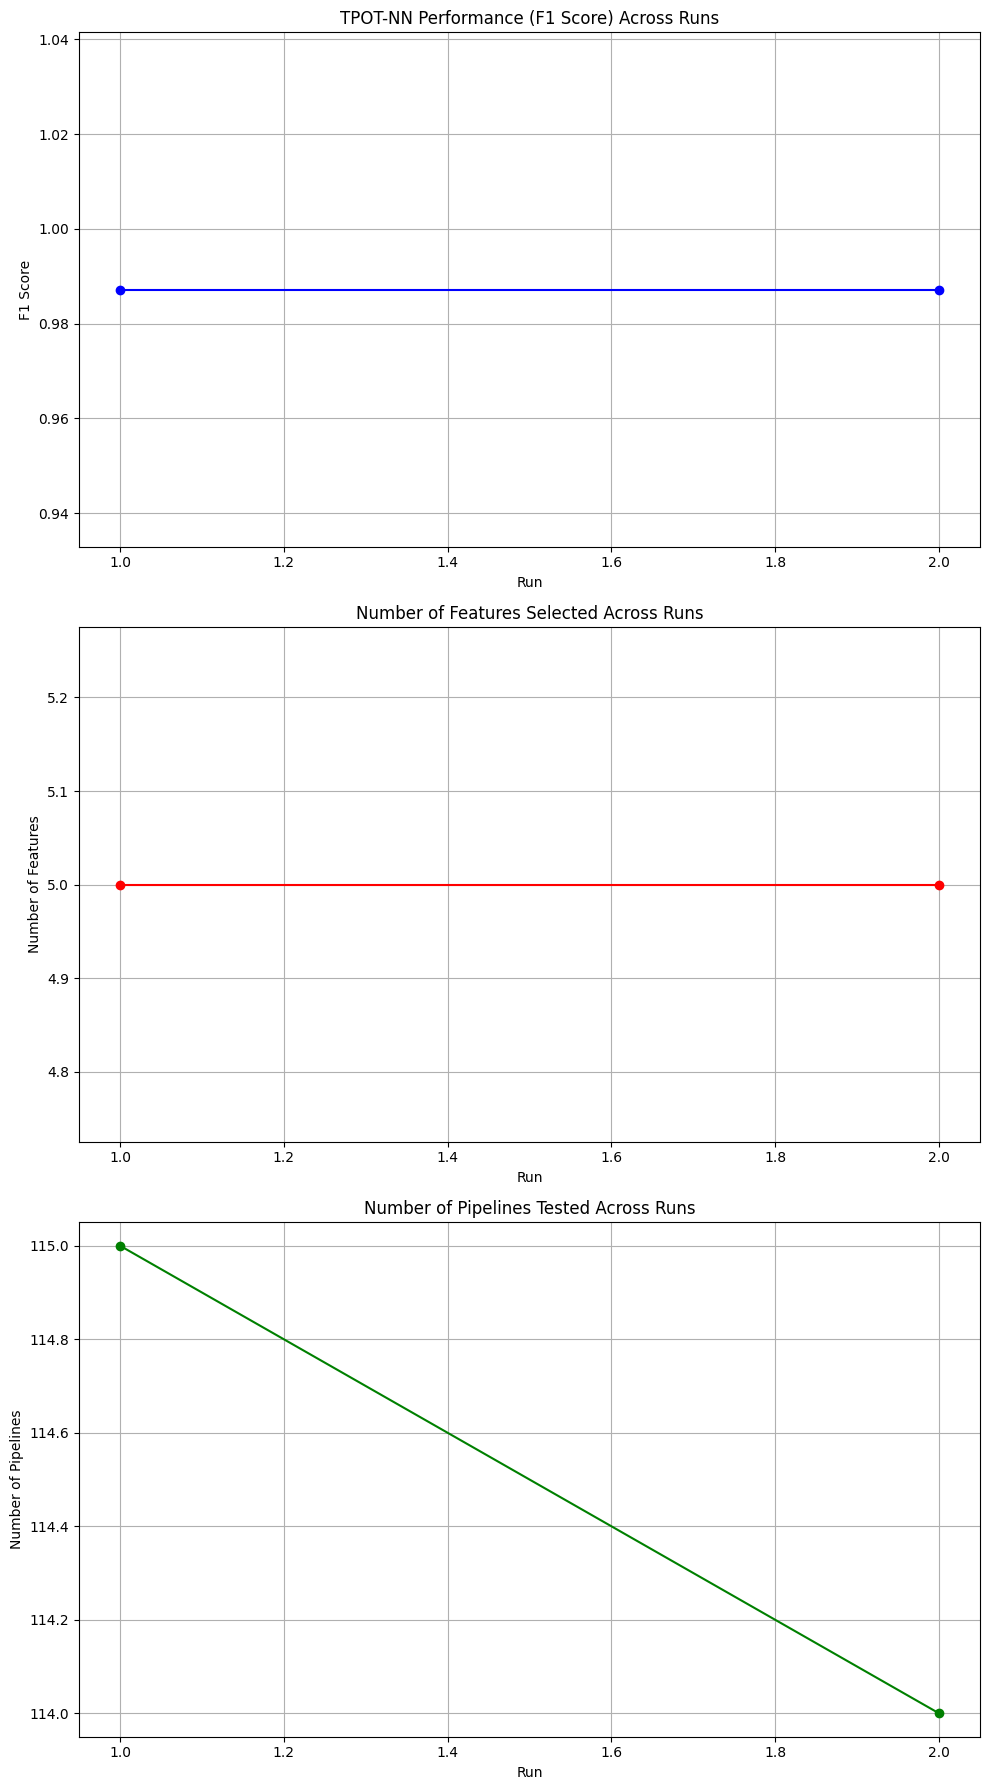


Summary Statistics:
            run  f1_score  n_features     runtime  pipelines_tested
count  2.000000  2.000000         2.0    2.000000          2.000000
mean   1.500000  0.987198         5.0  109.132951        114.500000
std    0.707107  0.000000         0.0    1.063263          0.707107
min    1.000000  0.987198         5.0  108.381110        114.000000
25%    1.250000  0.987198         5.0  108.757030        114.250000
50%    1.500000  0.987198         5.0  109.132951        114.500000
75%    1.750000  0.987198         5.0  109.508871        114.750000
max    2.000000  0.987198         5.0  109.884791        115.000000

Correlation Matrix:
                  f1_score  n_features  pipelines_tested  runtime
f1_score               NaN         NaN               NaN      NaN
n_features             NaN         NaN               NaN      NaN
pipelines_tested       NaN         NaN               1.0      1.0
runtime                NaN         NaN               1.0      1.0


In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

# Assuming results_df is your DataFrame with the results

fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(10, 18))

ax1.plot(results_df['run'], results_df['f1_score'], 'bo-')
ax1.set_title('TPOT-NN Performance (F1 Score) Across Runs')
ax1.set_xlabel('Run')
ax1.set_ylabel('F1 Score')
ax1.grid(True)

ax2.plot(results_df['run'], results_df['n_features'], 'ro-')
ax2.set_title('Number of Features Selected Across Runs')
ax2.set_xlabel('Run')
ax2.set_ylabel('Number of Features')
ax2.grid(True)

ax3.plot(results_df['run'], results_df['pipelines_tested'], 'go-')
ax3.set_title('Number of Pipelines Tested Across Runs')
ax3.set_xlabel('Run')
ax3.set_ylabel('Number of Pipelines')
ax3.grid(True)

plt.tight_layout()
plt.savefig('tpot_nn_performance_features_pipelines.png')
plt.show()

# Print summary statistics
print("\nSummary Statistics:")
print(results_df.describe())

# Optional: If you want to see the correlation between different metrics
correlation_matrix = results_df[['f1_score', 'n_features', 'pipelines_tested', 'runtime']].corr()
print("\nCorrelation Matrix:")
print(correlation_matrix)